In [43]:
!nvidia-smi

Fri Jan 28 23:09:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.29       Driver Version: 497.29       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   29C    P8    N/A /  N/A |     73MiB /  3072MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

# Scikit-Learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as MSE

# Ensemble Learning
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [46]:
data = pd.read_csv('FIFA_train.csv')

In [47]:
fifa_data = data.copy()

## Dataset 설명
### 해외 축구 선수 이적료 예측 데이터
1. id : 선수 고유의 아이디
2. name : 이름
3. age : 나이
4. continent : 선수들의 국적이 포함되어 있는 대륙입니다
5. contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다
6. position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
7. prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
8. reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
9. stat_overall : 선수의 현재 능력치 입니다.
10. stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
11. stat_skill_moves : 선수의 개인기 능력치 입니다.
12. value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다.

- 데이터 출처 : https://dacon.io/competitions/open/235538/data

In [48]:
# !pip install -U pandas-profiling
import pandas_profiling

In [49]:
pr = fifa_data.profile_report()
pr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
# !pip install dataprep
from dataprep.eda import *

  0%|                                                                                          | 0/486 [00:00<…


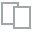
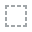
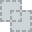
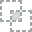
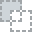
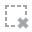
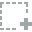
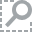
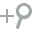
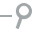
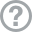
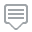
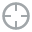
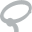
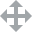
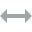
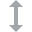
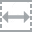
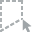
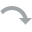
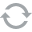
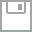
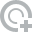
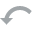
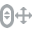
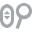
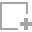
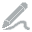
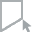
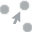
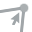
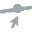

In [51]:
plot(fifa_data)

In [52]:
fifa_data.head()

id          name  age      continent contract_until position prefer_foot  \
0   0      L. Messi   31  south america           2021       ST        left   
1   3        De Gea   27         europe           2020       GK       right   
2   7     L. Suárez   31  south america           2021       ST       right   
3   8  Sergio Ramos   32         europe           2020       DF       right   
4   9      J. Oblak   25         europe           2021       GK       right   

   reputation  stat_overall  stat_potential  stat_skill_moves        value  
0         5.0            94              94               4.0  110500000.0  
1         4.0            91              93               1.0   72000000.0  
2         5.0            91              91               3.0   80000000.0  
3         4.0            91              91               3.0   51000000.0  
4         3.0            90              93               1.0   68000000.0

In [53]:
fifa_data.tail()

id                name  age      continent contract_until position  \
8927  16925          S. Adewusi   18         africa           2019       MF   
8928  16936           C. Ehlich   19         europe           2020       DF   
8929  16941          N. Fuentes   18  south america           2021       DF   
8930  16942            J. Milli   18         europe           2021       GK   
8931  16948  N. Christoffersson   19         europe           2020       ST   

     prefer_foot  reputation  stat_overall  stat_potential  stat_skill_moves  \
8927       right         1.0            48              63               3.0   
8928       right         1.0            47              59               2.0   
8929       right         1.0            47              64               2.0   
8930       right         1.0            47              65               1.0   
8931       right         1.0            47              63               2.0   

        value  
8927  60000.0  
8928  40000.0  
8929  50000.0  
8930  50000.0  
8931  60000.0

In [54]:
fifa_data.describe()

id          age   reputation  stat_overall  stat_potential  \
count   8932.000000  8932.000000  8932.000000   8932.000000     8932.000000   
mean    7966.775750    25.209136     1.130878     67.091133       71.997201   
std     4844.428521     4.635515     0.423792      6.854910        5.988147   
min        0.000000    16.000000     1.000000     47.000000       48.000000   
25%     3751.750000    21.000000     1.000000     63.000000       68.000000   
50%     7696.500000    25.000000     1.000000     67.000000       72.000000   
75%    12082.250000    28.000000     1.000000     72.000000       76.000000   
max    16948.000000    40.000000     5.000000     94.000000       94.000000   

       stat_skill_moves         value  
count       8932.000000  8.932000e+03  
mean           2.401702  2.778673e+06  
std            0.776048  5.840982e+06  
min            1.000000  1.000000e+04  
25%            2.000000  3.750000e+05  
50%            2.000000  8.250000e+05  
75%            3.000000  2.600000e+06  
max            5.000000  1.105000e+08

In [55]:
fifa_data.describe(include = 'all')

id     name          age continent contract_until position  \
count    8932.000000     8932  8932.000000      8932           8932     8932   
unique           NaN     8932          NaN         5             17        4   
top              NaN  A. Awad          NaN    europe           2019       MF   
freq             NaN        1          NaN      5322           2366     3428   
mean     7966.775750      NaN    25.209136       NaN            NaN      NaN   
std      4844.428521      NaN     4.635515       NaN            NaN      NaN   
min         0.000000      NaN    16.000000       NaN            NaN      NaN   
25%      3751.750000      NaN    21.000000       NaN            NaN      NaN   
50%      7696.500000      NaN    25.000000       NaN            NaN      NaN   
75%     12082.250000      NaN    28.000000       NaN            NaN      NaN   
max     16948.000000      NaN    40.000000       NaN            NaN      NaN   

       prefer_foot   reputation  stat_overall  stat_potential  \
count         8932  8932.000000   8932.000000     8932.000000   
unique           2          NaN           NaN             NaN   
top          right          NaN           NaN             NaN   
freq          6837          NaN           NaN             NaN   
mean           NaN     1.130878     67.091133       71.997201   
std            NaN     0.423792      6.854910        5.988147   
min            NaN     1.000000     47.000000       48.000000   
25%            NaN     1.000000     63.000000       68.000000   
50%            NaN     1.000000     67.000000       72.000000   
75%            NaN     1.000000     72.000000       76.000000   
max            NaN     5.000000     94.000000       94.000000   

        stat_skill_moves         value  
count        8932.000000  8.932000e+03  
unique               NaN           NaN  
top                  NaN           NaN  
freq                 NaN           NaN  
mean            2.401702  2.778673e+06  
std             0.776048  5.840982e+06  
min             1.000000  1.000000e+04  
25%             2.000000  3.750000e+05  
50%             2.000000  8.250000e+05  
75%             3.000000  2.600000e+06  
max             5.000000  1.105000e+08

In [56]:
fifa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


- 본 데이터에는 결측치가 존재하지 않습니다.
- 대신 데이터 전처리를 진행하겠습니다.

## 1. 데이터 전처리

### 1.1. Continent를 범주화
- 1 : 유럽
- 2 : 남미
- 3 : 아시아
- 4 : 아프리카
- 5 : 오세아니아

In [57]:
fifa_data.head()

id          name  age      continent contract_until position prefer_foot  \
0   0      L. Messi   31  south america           2021       ST        left   
1   3        De Gea   27         europe           2020       GK       right   
2   7     L. Suárez   31  south america           2021       ST       right   
3   8  Sergio Ramos   32         europe           2020       DF       right   
4   9      J. Oblak   25         europe           2021       GK       right   

   reputation  stat_overall  stat_potential  stat_skill_moves        value  
0         5.0            94              94               4.0  110500000.0  
1         4.0            91              93               1.0   72000000.0  
2         5.0            91              91               3.0   80000000.0  
3         4.0            91              91               3.0   51000000.0  
4         3.0            90              93               1.0   68000000.0

In [58]:
def continent_num(x):
    if x == 'europe':
        return 1
    elif x == 'south america':
        return 2
    elif x == 'asia':
        return 3
    elif x == 'africa':
        return 4
    elif x == 'oceania':
        return 5

In [59]:
fifa_data['continent_num'] = fifa_data.continent.apply(continent_num).astype('int64')
fifa_data = fifa_data.drop(columns=['continent'], axis=1)

In [60]:
fifa_data.head()

id          name  age contract_until position prefer_foot  reputation  \
0   0      L. Messi   31           2021       ST        left         5.0   
1   3        De Gea   27           2020       GK       right         4.0   
2   7     L. Suárez   31           2021       ST       right         5.0   
3   8  Sergio Ramos   32           2020       DF       right         4.0   
4   9      J. Oblak   25           2021       GK       right         3.0   

   stat_overall  stat_potential  stat_skill_moves        value  continent_num  
0            94              94               4.0  110500000.0              2  
1            91              93               1.0   72000000.0              1  
2            91              91               3.0   80000000.0              2  
3            91              91               3.0   51000000.0              1  
4            90              93               1.0   68000000.0              1

### 1.2. Contract_until을 수정 
- 본 데이터는 2018년 기준이기 때문에 2018년부터 남은 기간을 채택

In [61]:
def contract_calculate(x):
    if len(x) > 4:
        a = int(x[-4:])
        return a
    else:
        return x

In [62]:
fifa_data['contract_year'] = 2018
fifa_data['contract_period'] = fifa_data.contract_until.apply(contract_calculate).astype('int64')
fifa_data['contract_period'] -= fifa_data['contract_year']
fifa_data = fifa_data.drop(columns=['contract_until', 'contract_year'], axis=1)

In [63]:
fifa_data.head()

id          name  age position prefer_foot  reputation  stat_overall  \
0   0      L. Messi   31       ST        left         5.0            94   
1   3        De Gea   27       GK       right         4.0            91   
2   7     L. Suárez   31       ST       right         5.0            91   
3   8  Sergio Ramos   32       DF       right         4.0            91   
4   9      J. Oblak   25       GK       right         3.0            90   

   stat_potential  stat_skill_moves        value  continent_num  \
0              94               4.0  110500000.0              2   
1              93               1.0   72000000.0              1   
2              91               3.0   80000000.0              2   
3              91               3.0   51000000.0              1   
4              93               1.0   68000000.0              1   

   contract_period  
0                3  
1                2  
2                3  
3                2  
4                3

### 1.3. Position을 범주화
- 1 : 골키퍼
- 2 : 수비수
- 3 : 미드필더
- 4 : 공격수

In [64]:
def position_num(x):
    if x == 'GK':
        return 1
    elif x == 'DF':
        return 2
    elif x == 'MF':
        return 3
    elif x == 'ST':
        return 4

In [65]:
fifa_data['position_num'] = fifa_data.position.apply(position_num).astype('int64')
fifa_data = fifa_data.drop(columns=['position'], axis=1)

In [66]:
fifa_data.head()

id          name  age prefer_foot  reputation  stat_overall  \
0   0      L. Messi   31        left         5.0            94   
1   3        De Gea   27       right         4.0            91   
2   7     L. Suárez   31       right         5.0            91   
3   8  Sergio Ramos   32       right         4.0            91   
4   9      J. Oblak   25       right         3.0            90   

   stat_potential  stat_skill_moves        value  continent_num  \
0              94               4.0  110500000.0              2   
1              93               1.0   72000000.0              1   
2              91               3.0   80000000.0              2   
3              91               3.0   51000000.0              1   
4              93               1.0   68000000.0              1   

   contract_period  position_num  
0                3             4  
1                2             1  
2                3             4  
3                2             2  
4                3             1

### 1.4. 선호발(prefer_foot)은 One-Hot Encoding으로 변환

In [67]:
def prefer_foot_num(x):
    if x == 'left':
        return 0
    elif x == 'right':
        return 1

In [68]:
fifa_data['prefer_foot_num'] = fifa_data.prefer_foot.apply(prefer_foot_num).astype('int64')
fifa_data = fifa_data.drop(columns=['prefer_foot'], axis=1)

In [69]:
fifa_data.head()

id          name  age  reputation  stat_overall  stat_potential  \
0   0      L. Messi   31         5.0            94              94   
1   3        De Gea   27         4.0            91              93   
2   7     L. Suárez   31         5.0            91              91   
3   8  Sergio Ramos   32         4.0            91              91   
4   9      J. Oblak   25         3.0            90              93   

   stat_skill_moves        value  continent_num  contract_period  \
0               4.0  110500000.0              2                3   
1               1.0   72000000.0              1                2   
2               3.0   80000000.0              2                3   
3               3.0   51000000.0              1                2   
4               1.0   68000000.0              1                3   

   position_num  prefer_foot_num  
0             4                0  
1             1                1  
2             4                1  
3             2                1  
4             1                1

### 1.5. 데이터 분석에서 불필요한 Column들 제거
- id, name 제거

In [70]:
fifa_data = fifa_data.drop(columns=['id', 'name'], axis=1)

In [71]:
fifa_data.head()

age  reputation  stat_overall  stat_potential  stat_skill_moves  \
0   31         5.0            94              94               4.0   
1   27         4.0            91              93               1.0   
2   31         5.0            91              91               3.0   
3   32         4.0            91              91               3.0   
4   25         3.0            90              93               1.0   

         value  continent_num  contract_period  position_num  prefer_foot_num  
0  110500000.0              2                3             4                0  
1   72000000.0              1                2             1                1  
2   80000000.0              2                3             4                1  
3   51000000.0              1                2             2                1  
4   68000000.0              1                3             1                1

### 1.6. Column 순서 변경
- 데이터 분석의 편의성을 위함

In [72]:
fifa_data = fifa_data[['age', 'continent_num', 'contract_period', 
                       'position_num', 'prefer_foot_num', 'reputation', 
                       'stat_overall', 'stat_potential', 'stat_skill_moves', 'value']]

In [73]:
fifa_data.head()

age  continent_num  contract_period  position_num  prefer_foot_num  \
0   31              2                3             4                0   
1   27              1                2             1                1   
2   31              2                3             4                1   
3   32              1                2             2                1   
4   25              1                3             1                1   

   reputation  stat_overall  stat_potential  stat_skill_moves        value  
0         5.0            94              94               4.0  110500000.0  
1         4.0            91              93               1.0   72000000.0  
2         5.0            91              91               3.0   80000000.0  
3         4.0            91              91               3.0   51000000.0  
4         3.0            90              93               1.0   68000000.0

## 2. 데이터 시각화

In [226]:
def pie_plot(feature):
    plt.figure(figsize=(12, 8))
    fifa_data[feature].value_counts().plot.pie(autopct='%1.1f%%')

In [227]:
def count_plot(feature):
    plt.figure(figsize=(12, 8))
    g1 = sns.countplot(data = fifa_data, x = feature)
    g1.set_title(f"{feature} Distribution")
    plt.show()

In [228]:
def bar_plot(feature):
    plt.figure(figsize=(12, 8))
    g2 = sns.barplot(x=fifa_data['age'],y=fifa_data[feature])
    plt.xticks(rotation=45)
    plt.show()

### 2.1. continent_num 시각화

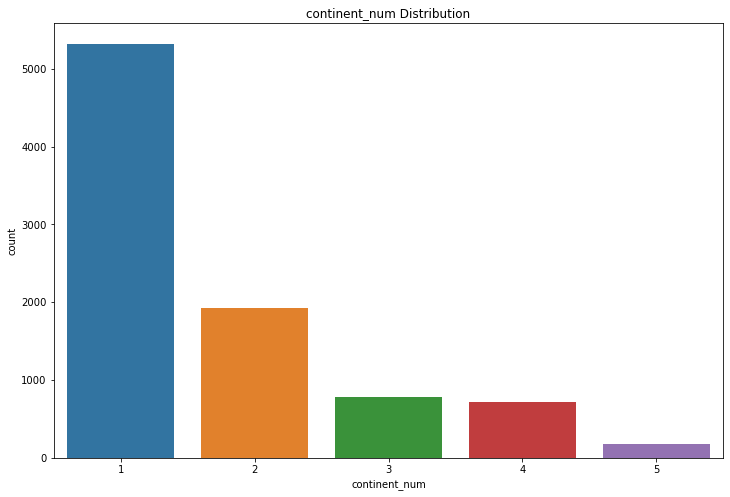

In [229]:
count_plot('continent_num')

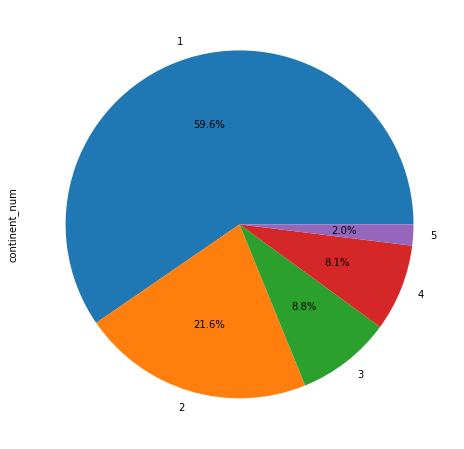

In [230]:
pie_plot("continent_num")

- 유럽, 남미, 아시아, 아프리카, 오세아니아 순으로 선수들이 많은 것으로 알 수 있다.
- 본 데이터를 FIFA가 제공해주었다는 것을 고려할 때, 축구 종주국이 영국이고 유럽 5대 리그(EPL, LaLiga, 세리에A, 분데스리가, 리그앙)가 세계 최정상급 리그이기도 하니 유럽 선수들이 가장 많은 것은 어쩔 수 없는 현상인 것 같다.
- 남미에서는 브라질, 아르헨티나 등 축구 강국들이 있기 때문에 유럽에 이은 남아메리카가 2위를 차지한 것 같다.
- 아시아와 아프리카는 또이또이하다.
- 오세아니아는 대륙 자체가 작고 그나마 축구를 잘하는 국가가 호주 밖에 없기 때문에 가장 축구선수 수가 적은 것은 어쩔 수 없는 것 같다.

### 2.2. 나이와 축구선수의 포텐
- X축에는 선수의 나이를, Y축에는 stat_potential에서 stat_overall을 뺀 값을 지정해봄으로써 나이에 따른 선수의 포텐을 계산해보자.

In [75]:
fifa_data.head()

age  continent_num  contract_period  position_num  prefer_foot_num  \
0   31              2                3             4                0   
1   27              1                2             1                1   
2   31              2                3             4                1   
3   32              1                2             2                1   
4   25              1                3             1                1   

   reputation  stat_overall  stat_potential  stat_skill_moves        value  
0         5.0            94              94               4.0  110500000.0  
1         4.0            91              93               1.0   72000000.0  
2         5.0            91              91               3.0   80000000.0  
3         4.0            91              91               3.0   51000000.0  
4         3.0            90              93               1.0   68000000.0

In [77]:
check_data = fifa_data.copy()

In [79]:
check_data.head()

age  continent_num  contract_period  position_num  prefer_foot_num  \
0   31              2                3             4                0   
1   27              1                2             1                1   
2   31              2                3             4                1   
3   32              1                2             2                1   
4   25              1                3             1                1   

   reputation  stat_overall  stat_potential  stat_skill_moves        value  
0         5.0            94              94               4.0  110500000.0  
1         4.0            91              93               1.0   72000000.0  
2         5.0            91              91               3.0   80000000.0  
3         4.0            91              91               3.0   51000000.0  
4         3.0            90              93               1.0   68000000.0

In [80]:
check_data['stat_difference'] = check_data['stat_potential'] - check_data['stat_overall']

In [81]:
check_data.head()

age  continent_num  contract_period  position_num  prefer_foot_num  \
0   31              2                3             4                0   
1   27              1                2             1                1   
2   31              2                3             4                1   
3   32              1                2             2                1   
4   25              1                3             1                1   

   reputation  stat_overall  stat_potential  stat_skill_moves        value  \
0         5.0            94              94               4.0  110500000.0   
1         4.0            91              93               1.0   72000000.0   
2         5.0            91              91               3.0   80000000.0   
3         4.0            91              91               3.0   51000000.0   
4         3.0            90              93               1.0   68000000.0   

   stat_difference  
0                0  
1                2  
2                0  
3                0  
4                3

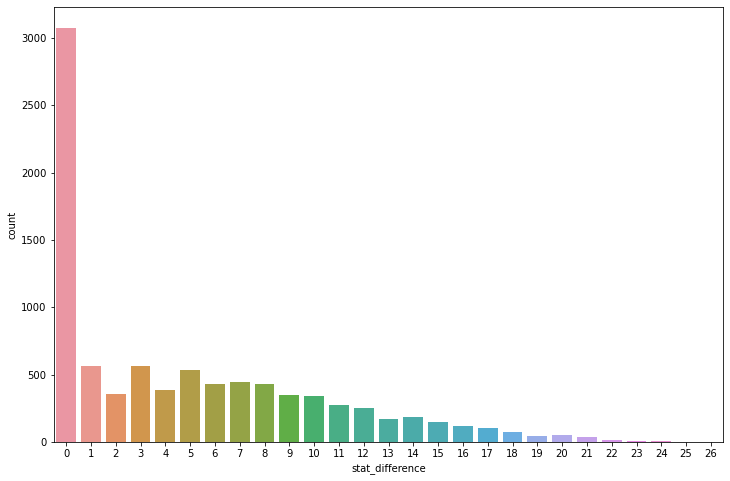

In [231]:
plt.figure(figsize=(12, 8))
sns.countplot(check_data['stat_difference'])
plt.show()

<AxesSubplot:ylabel='stat_difference'>

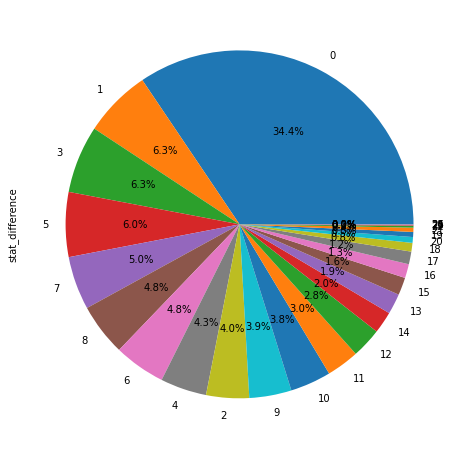

In [232]:
plt.figure(figsize=(12, 8))
check_data['stat_difference'].value_counts().plot.pie(autopct='%1.1f%%')

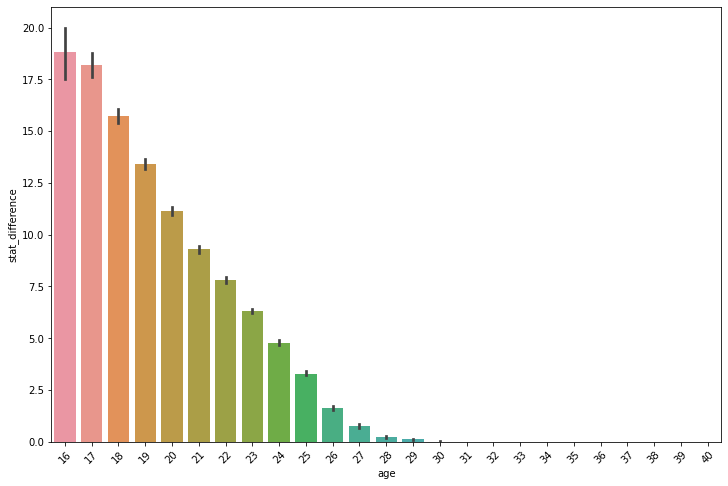

In [233]:
plt.figure(figsize=(12, 8))
g2 = sns.barplot(x=check_data['age'],y=check_data['stat_difference'])
plt.xticks(rotation=45)
plt.show()

In [99]:
check_data['stat_difference'].value_counts()

0     3076
1      562
3      561
5      537
7      443
8      433
6      427
4      384
2      356
9      350
10     339
11     271
12     250
14     182
13     170
15     146
16     116
17     105
18      72
20      48
19      42
21      35
22      15
23       5
24       4
25       2
26       1
Name: stat_difference, dtype: int64

In [100]:
check_data['stat_difference'].describe()

count    8932.000000
mean        4.906068
std         5.311906
min         0.000000
25%         0.000000
50%         3.000000
75%         8.000000
max        26.000000
Name: stat_difference, dtype: float64

- **Min = 0, Q1 = 0, Q2 = 3, Q3 = 8, Q4 = 26**
- 우선 선수의 포텐을 describe로 사분위수를 확인해보고 countplot으로 얼마나 분포가 되어있는지 확인해보았다.
- 선수의 발전이 없을 예정이라는 것을 의미하는 0이 압도적으로 많다. Q1을 넘어 Q2 가기 전까지 0이다.
- 신기한 것은 stat이 무려 최대 26씩이나 오를 수 있다는 데이터도 있다. (FIFA 게임에서 OVR 24 올릴려면 강화를 몇번해야 되나... 금카 만들어야 하지 않나 ㅎ..)

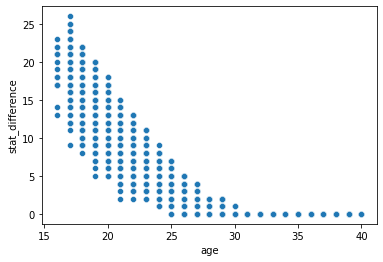

In [101]:
ax = sns.scatterplot(x=check_data['age'], y=check_data['stat_difference'])

- stat_difference가 0인 것은 25세부터 존재한다. 축구선수의 전성기가 20대 중반~후반임을 감안하면 합리적이다. 전성기를 못 누리고 은퇴하는 경우도 있기 때문이다.
- 10대 중후반부터 20대 초반까지에서 포텐을 많이 보이고 있다.
- 특히 10대 중후반인 17, 18세에 포텐을 많이 보이고 있는데, 신(神)계에 도달하는 축구선수들이 보통 이때 많은 포텐을 보인다는 것을 고려한다면 합당하다.
- 참고로, 1985년생인 우리형 호날두는 2002년 스포르팅 CP 성인 무대에서 데뷔하였으며, 엄청난 포텐을 보인 덕분에 2003년 맨체스터 유나이티드로 넘어가서 7번을 달았다. 이때의 연령대가 만 나이 기준 17~18세다.
- 1987년생인 리오넬 메시는 2004년에 FC 바르셀로나 성인 무대에 데뷔하였다. 이때의 연령대 역시 16~17세 근방이다.

In [108]:
age_with_diff = check_data.groupby(['age', 'stat_difference']).size().unstack()

In [109]:
age_with_diff

stat_difference     0      1      2      3      4      5      6      7   \
age                                                                       
16                 NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
17                 NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18                 NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
19                 NaN    NaN    NaN    NaN    NaN    1.0    1.0    2.0   
20                 NaN    NaN    NaN    NaN    NaN    3.0    7.0   26.0   
21                 NaN    NaN    1.0    1.0    4.0   12.0   32.0   81.0   
22                 NaN    NaN    1.0    4.0   15.0   52.0   82.0  133.0   
23                 NaN    NaN    2.0    9.0   56.0  153.0  166.0  127.0   
24                 NaN    3.0   26.0  109.0  156.0  189.0  119.0   69.0   
25                 2.0   61.0   98.0  242.0  116.0  110.0   20.0    5.0   
26               158.0  220.0  124.0  156.0   33.0   17.0    NaN    NaN   
27               293.0  186.0   58.0   40.0    4.0    NaN    NaN    NaN   
28               439.0   56.0   37.0    NaN    NaN    NaN    NaN    NaN   
29               429.0   34.0    9.0    NaN    NaN    NaN    NaN    NaN   
30               474.0    2.0    NaN    NaN    NaN    NaN    NaN    NaN   
31               347.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
32               285.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
33               202.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
34               216.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
35                89.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
36                64.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
37                42.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
38                17.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
39                16.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
40                 3.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

stat_difference     8      9   ...    17    18    19    20    21   22   23  \
age                            ...                                           
16                 NaN    NaN  ...   4.0   3.0   1.0   1.0   4.0  2.0  1.0   
17                 NaN    1.0  ...  14.0  16.0   6.0  18.0  17.0  8.0  4.0   
18                 1.0    6.0  ...  39.0  31.0  28.0  24.0  14.0  5.0  NaN   
19                11.0   19.0  ...  38.0  20.0   7.0   5.0   NaN  NaN  NaN   
20                56.0   65.0  ...  10.0   2.0   NaN   NaN   NaN  NaN  NaN   
21               128.0  111.0  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
22               130.0   99.0  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
23                88.0   48.0  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
24                19.0    1.0  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
25                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
26                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
27                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
28                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
29                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
30                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
31                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
32                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
33                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
34                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
35                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
36                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
37                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
38                 NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   
39                 NaN  

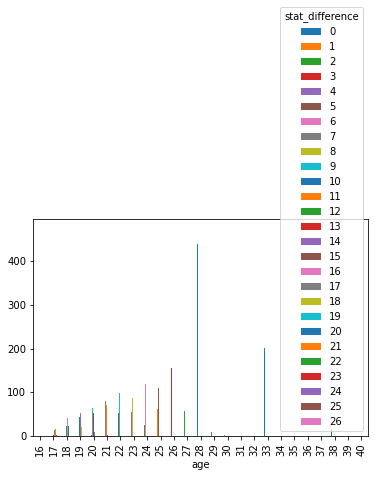

In [110]:
age_with_diff.plot(kind='bar')
plt.show()

In [121]:
age_with_diff_1 = check_data.groupby(['age', 'stat_difference']).mean()
age_with_diff_1

continent_num  contract_period  position_num  \
age stat_difference                                                 
16  13                    1.000000         3.000000      3.000000   
    14                    1.000000         1.000000      3.000000   
    17                    3.000000         1.250000      3.500000   
    18                    1.000000         2.666667      3.000000   
    19                    4.000000         2.000000      3.000000   
...                            ...              ...           ...   
36  0                     1.843750         1.890625      2.312500   
37  0                     1.523810         1.452381      1.880952   
38  0                     1.823529         1.764706      2.117647   
39  0                     1.687500         2.062500      2.000000   
40  0                     1.666667         1.666667      1.000000   

                     prefer_foot_num  reputation  stat_overall  \
age stat_difference                                              
16  13                      1.000000    1.000000     62.000000   
    14                      1.000000    1.000000     58.000000   
    17                      0.500000    1.000000     53.500000   
    18                      0.666667    1.000000     56.666667   
    19                      1.000000    1.000000     52.000000   
...                              ...         ...           ...   
36  0                       0.875000    1.421875     69.156250   
37  0                       0.857143    1.238095     68.904762   
38  0                       0.882353    1.470588     67.352941   
39  0                       0.812500    1.437500     70.625000   
40  0                       1.000000    2.000000     75.666667   

                     stat_potential  stat_skill_moves         value  
age stat_difference                                                  
16  13                    75.000000          2.000000  4.500000e+05  
    14                    72.000000          3.000000  2.500000e+05  
    17                    70.500000          2.000000  1.275000e+05  
    18                    74.666667          2.333333  3.583333e+05  
    19                    71.000000          2.000000  1.000000e+05  
...                             ...               ...           ...  
36  0                     69.156250          2.046875  7.871094e+05  
37  0                     68.904762          1.809524  6.603571e+05  
38  0                     67.352941          1.823529  1.958824e+05  
39  0                     70.625000          1.875000  3.381250e+05  
40  0                     75.666667          1.000000  1.436667e+06  

[153 rows x 9 columns]

### 2.3. 나이와 계약기간

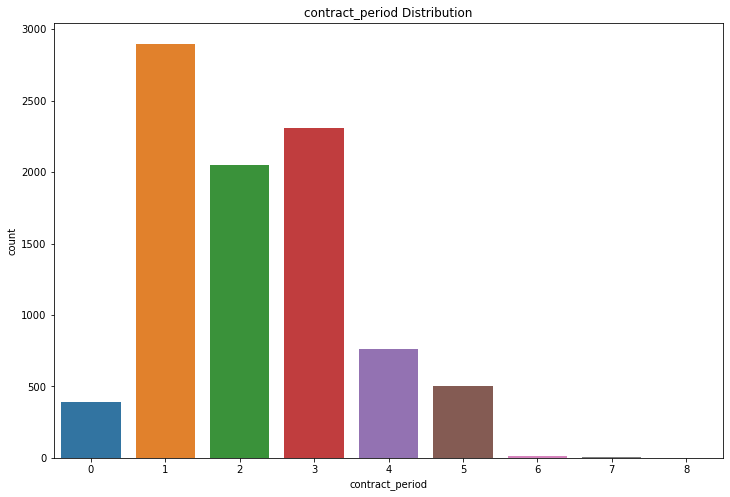

In [234]:
count_plot('contract_period')

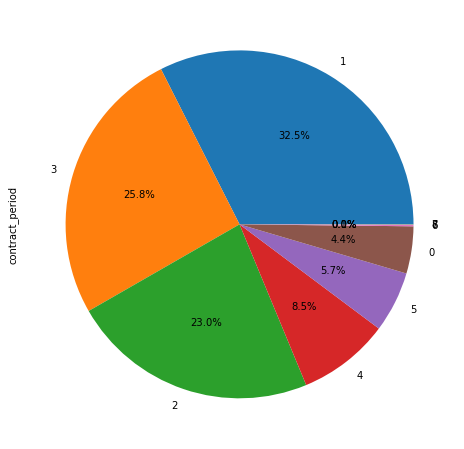

In [235]:
pie_plot('contract_period')

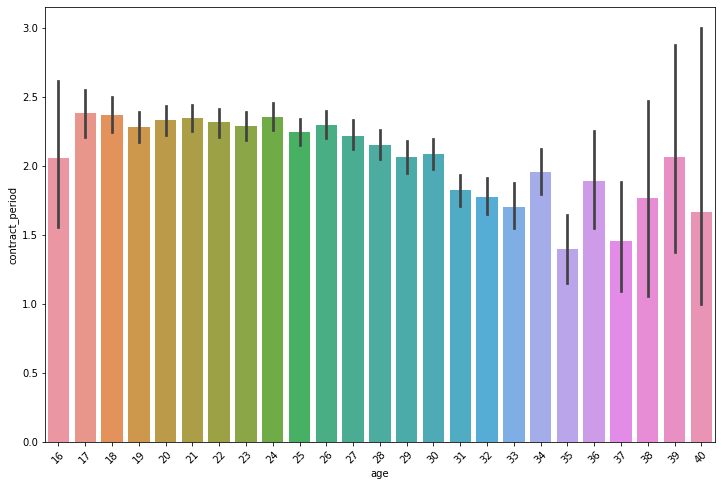

In [236]:
bar_plot('contract_period')

In [166]:
check_data['contract_period'].value_counts()

1    2899
3    2308
2    2051
4     761
5     506
0     391
6      12
7       3
8       1
Name: contract_period, dtype: int64

In [167]:
check_data['contract_period'].describe()

count    8932.000000
mean        2.194357
std         1.266901
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: contract_period, dtype: float64

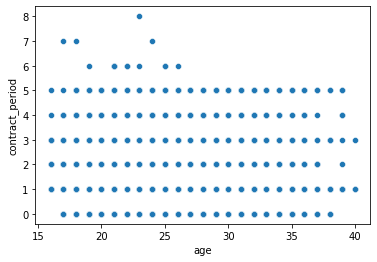

In [169]:
ax = sns.scatterplot(x=check_data['age'], y=check_data['contract_period'])

- 계약기간이 1년이 남은 선수들이 가장 많고, 3년, 2년, 4년, 5년, 0년 등의 순으로 이루어져 있다.

In [172]:
age_with_contract = check_data.groupby(['age', 'contract_period']).size().unstack()

In [173]:
age_with_contract

contract_period     0      1      2      3     4     5    6    7    8
age                                                                  
16                NaN    8.0    4.0    4.0   1.0   1.0  NaN  NaN  NaN
17                6.0   20.0   33.0   66.0   4.0   1.0  NaN  1.0  NaN
18               10.0   92.0   71.0  126.0  24.0  20.0  NaN  1.0  NaN
19               12.0  156.0   92.0  168.0  40.0  22.0  1.0  NaN  NaN
20               23.0  161.0  122.0  183.0  64.0  29.0  NaN  NaN  NaN
21               15.0  209.0  154.0  177.0  72.0  44.0  5.0  NaN  NaN
22               20.0  202.0  137.0  157.0  65.0  49.0  2.0  NaN  NaN
23               30.0  203.0  156.0  152.0  68.0  52.0  1.0  NaN  1.0
24               23.0  216.0  132.0  188.0  79.0  52.0  NaN  1.0  NaN
25               24.0  197.0  182.0  135.0  81.0  33.0  2.0  NaN  NaN
26               31.0  208.0  143.0  218.0  65.0  42.0  1.0  NaN  NaN
27               28.0  175.0  141.0  145.0  64.0  28.0  NaN  NaN  NaN
28               22.0  161.0  155.0  129.0  38.0  27.0  NaN  NaN  NaN
29               35.0  146.0  135.0   96.0  31.0  29.0  NaN  NaN  NaN
30               33.0  142.0  115.0  143.0  24.0  19.0  NaN  NaN  NaN
31               13.0  150.0  105.0   55.0  12.0  12.0  NaN  NaN  NaN
32               16.0  130.0   74.0   46.0   5.0  14.0  NaN  NaN  NaN
33               13.0   97.0   55.0   22.0   5.0  10.0  NaN  NaN  NaN
34               13.0   89.0   25.0   78.0   6.0   5.0  NaN  NaN  NaN
35               12.0   55.0    9.0    6.0   2.0   5.0  NaN  NaN  NaN
36                5.0   34.0    6.0    6.0   8.0   5.0  NaN  NaN  NaN
37                4.0   28.0    4.0    2.0   1.0   3.0  NaN  NaN  NaN
38                3.0    8.0    NaN    4.0   NaN   2.0  NaN  NaN  NaN
39                NaN   10.0    1.0    1.0   2.0   2.0  NaN  NaN  NaN
40                NaN    2.0    NaN    1.0   NaN   NaN  NaN  NaN  NaN

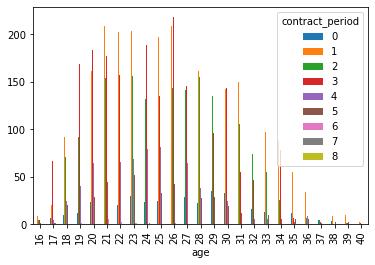

In [177]:
age_with_contract.plot(kind='bar')
plt.show()

### 2.4. 나이와 능력치

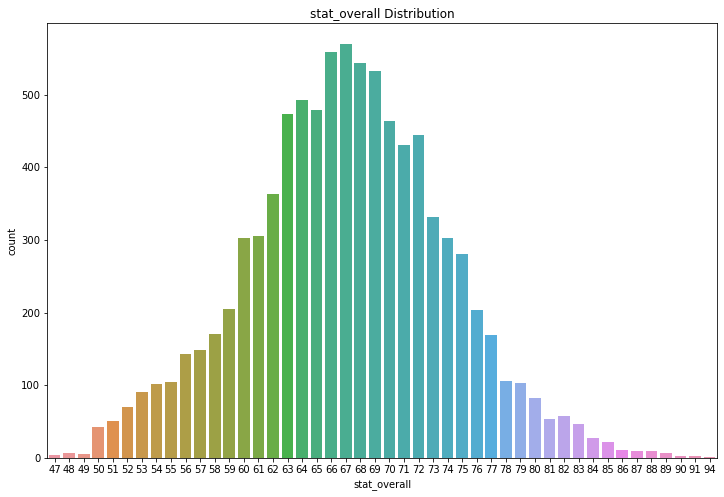

In [237]:
# plt.figure(figsize=(12, 8))
# sns.countplot(check_data['stat_overall'])
# plt.show()

count_plot('stat_overall')

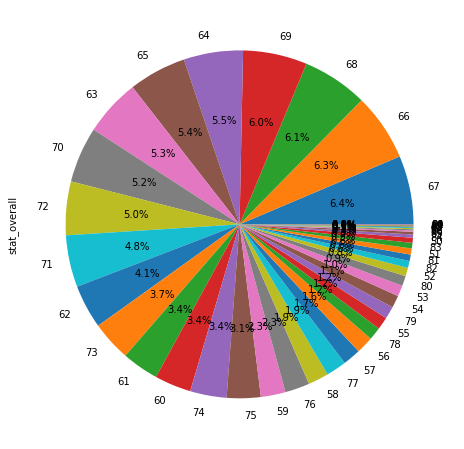

In [238]:
pie_plot('stat_overall')

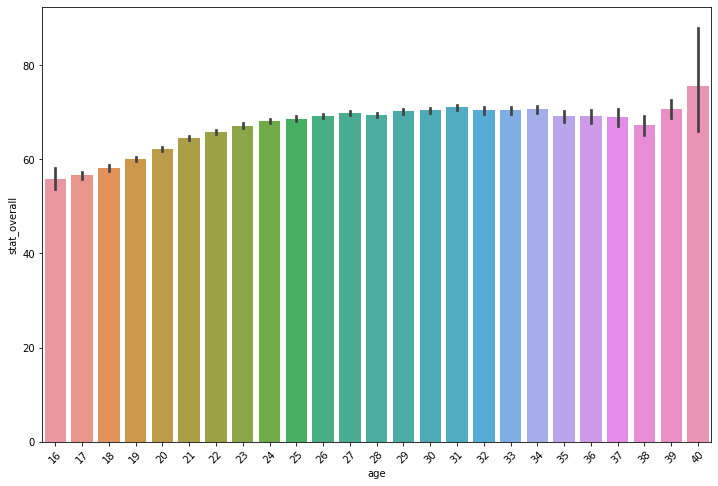

In [239]:
bar_plot('stat_overall')

In [179]:
check_data['stat_overall'].value_counts()

67    570
66    559
68    543
69    532
64    492
65    479
63    473
70    463
72    445
71    431
62    363
73    332
61    305
60    303
74    303
75    281
59    205
76    204
58    170
77    169
57    148
56    143
78    106
55    104
79    103
54    102
53     91
80     83
52     70
82     58
81     53
51     51
83     46
50     42
84     27
85     22
86     11
88     10
87      9
48      7
89      7
49      6
47      4
90      3
91      3
94      1
Name: stat_overall, dtype: int64

In [180]:
check_data['stat_overall'].describe()

count    8932.000000
mean       67.091133
std         6.854910
min        47.000000
25%        63.000000
50%        67.000000
75%        72.000000
max        94.000000
Name: stat_overall, dtype: float64

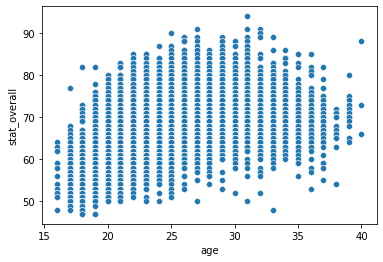

In [181]:
ax = sns.scatterplot(x=check_data['age'], y=check_data['stat_overall'])

In [182]:
age_with_overall = check_data.groupby(['age', 'stat_overall']).size().unstack()

In [183]:
age_with_overall

stat_overall   47   48   49    50    51    52    53    54    55    56  ...  \
age                                                                    ...   
16            NaN  1.0  NaN   NaN   2.0   4.0   1.0   1.0   NaN   1.0  ...   
17            NaN  1.0  3.0   8.0   9.0  10.0   8.0  13.0   9.0  10.0  ...   
18            2.0  4.0  2.0  14.0  12.0  18.0  27.0  18.0  24.0  23.0  ...   
19            2.0  NaN  1.0  10.0  14.0  16.0  25.0  24.0  24.0  33.0  ...   
20            NaN  NaN  NaN   5.0   9.0   4.0  12.0  14.0  14.0  30.0  ...   
21            NaN  NaN  NaN   1.0   2.0  13.0   7.0  14.0  11.0  12.0  ...   
22            NaN  NaN  NaN   NaN   1.0   1.0   4.0   5.0   6.0   6.0  ...   
23            NaN  NaN  NaN   1.0   1.0   NaN   3.0   7.0   5.0  11.0  ...   
24            NaN  NaN  NaN   1.0   NaN   1.0   NaN   2.0   3.0   5.0  ...   
25            NaN  NaN  NaN   NaN   1.0   1.0   1.0   1.0   4.0   3.0  ...   
26            NaN  NaN  NaN   NaN   NaN   NaN   1.0   1.0   NaN   3.0  ...   
27            NaN  NaN  NaN   1.0   NaN   NaN   NaN   NaN   2.0   NaN  ...   
28            NaN  NaN  NaN   NaN   NaN   NaN   NaN   1.0   NaN   3.0  ...   
29            NaN  NaN  NaN   NaN   NaN   NaN   1.0   NaN   1.0   NaN  ...   
30            NaN  NaN  NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN  ...   
31            NaN  NaN  NaN   1.0   NaN   NaN   NaN   NaN   NaN   1.0  ...   
32            NaN  NaN  NaN   NaN   NaN   1.0   NaN   NaN   NaN   1.0  ...   
33            NaN  1.0  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
34            NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
35            NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0  ...   
36            NaN  NaN  NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN  ...   
37            NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN  ...   
38            NaN  NaN  NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN  ...   
39            NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
40            NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

stat_overall   83   84   85   86   87   88   89   90   91   94  
age                                                             
16            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
17            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
18            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
19            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
21            2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
22            5.0  2.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
23            2.0  1.0  3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
24            3.0  3.0  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  
25            3.0  2.0  1.0  1.0  2.0  NaN  NaN  1.0  NaN  NaN  
26            5.0  4.0  1.0  2.0  NaN  4.0  2.0  NaN  NaN  NaN  
27            2.0  1.0  1.0  3.0  1.0  1.0  1.0  NaN  1.0  NaN  
28            5.0  2.0  2.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  
29            6.0  3.0  3.0  1.0  1.0  2.0  1.0  NaN  NaN  NaN  
30            6.0  2.0  2.0  NaN  2.0  1.0  NaN  NaN  NaN  NaN  
31            3.0  2.0  3.0  1.0  2.0  1.0  1.0  NaN  1.0  1.0  
32            NaN  2.0  2.0  NaN  NaN  NaN  1.0  2.0  1.0  NaN  
33            2.0  NaN  NaN  1.0  NaN  NaN  1.0  NaN  NaN  NaN  
34            1.0  3.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  
35            1.0  NaN  2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
36            NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
37            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
38            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
39            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
40            NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  

[25 rows x 46 columns]

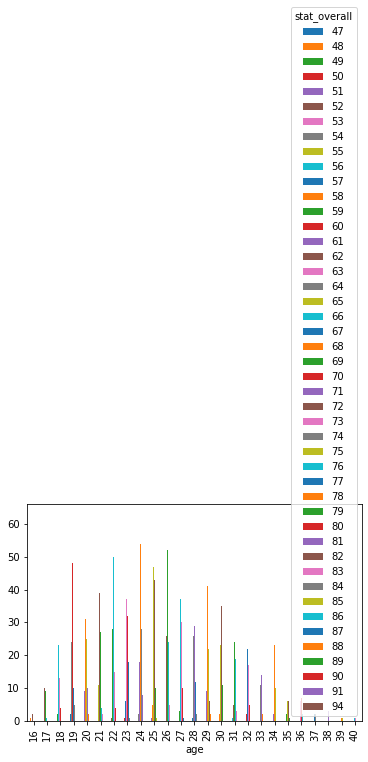

In [184]:
age_with_overall.plot(kind='bar')
plt.show()

## 3. 수치형 변수간 상관관계 파악

In [185]:
num_cols_data_cor = fifa_data.corr()
num_cols_data_cor

age  continent_num  contract_period  position_num  \
age               1.000000       0.041284        -0.132052     -0.082385   
continent_num     0.041284       1.000000         0.033707      0.066974   
contract_period  -0.132052       0.033707         1.000000      0.028342   
position_num     -0.082385       0.066974         0.028342      1.000000   
prefer_foot_num   0.007760       0.021831        -0.004760      0.015746   
reputation        0.263468      -0.054122         0.070446      0.033550   
stat_overall      0.467345      -0.056798         0.156983      0.064339   
stat_potential   -0.231303      -0.112254         0.258477      0.093973   
stat_skill_moves  0.039362       0.035011         0.082641      0.621450   
value             0.087319      -0.053271         0.228638      0.080808   

                  prefer_foot_num  reputation  stat_overall  stat_potential  \
age                      0.007760    0.263468      0.467345       -0.231303   
continent_num            0.021831   -0.054122     -0.056798       -0.112254   
contract_period         -0.004760    0.070446      0.156983        0.258477   
position_num             0.015746    0.033550      0.064339        0.093973   
prefer_foot_num          1.000000    0.003859     -0.036585       -0.029030   
reputation               0.003859    1.000000      0.521389        0.399183   
stat_overall            -0.036585    0.521389      1.000000        0.665453   
stat_potential          -0.029030    0.399183      0.665453        1.000000   
stat_skill_moves        -0.109107    0.196582      0.400164        0.332578   
value                   -0.008204    0.665982      0.658444        0.611907   

                  stat_skill_moves     value  
age                       0.039362  0.087319  
continent_num             0.035011 -0.053271  
contract_period           0.082641  0.228638  
position_num              0.621450  0.080808  
prefer_foot_num          -0.109107 -0.008204  
reputation                0.196582  0.665982  
stat_overall              0.400164  0.658444  
stat_potential            0.332578  0.611907  
stat_skill_moves          1.000000  0.298500  
value                     0.298500  1.000000

<AxesSubplot:>

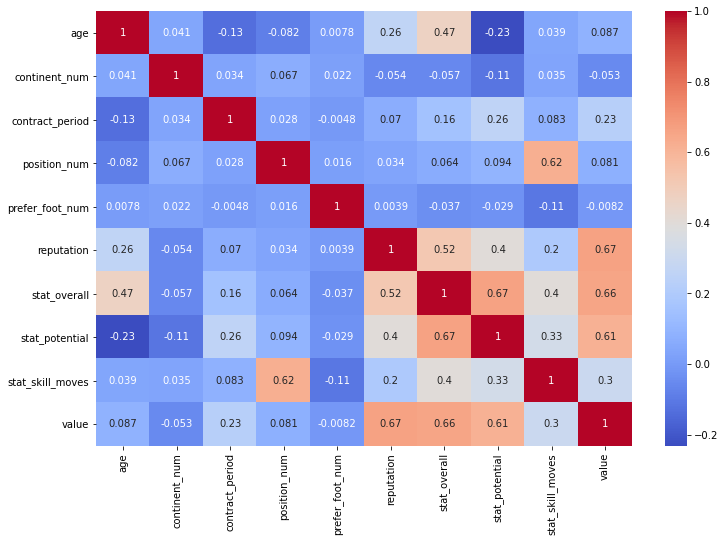

In [186]:
plt.figure(figsize=(12,8))
sns.heatmap(num_cols_data_cor,cmap='coolwarm', annot=True)

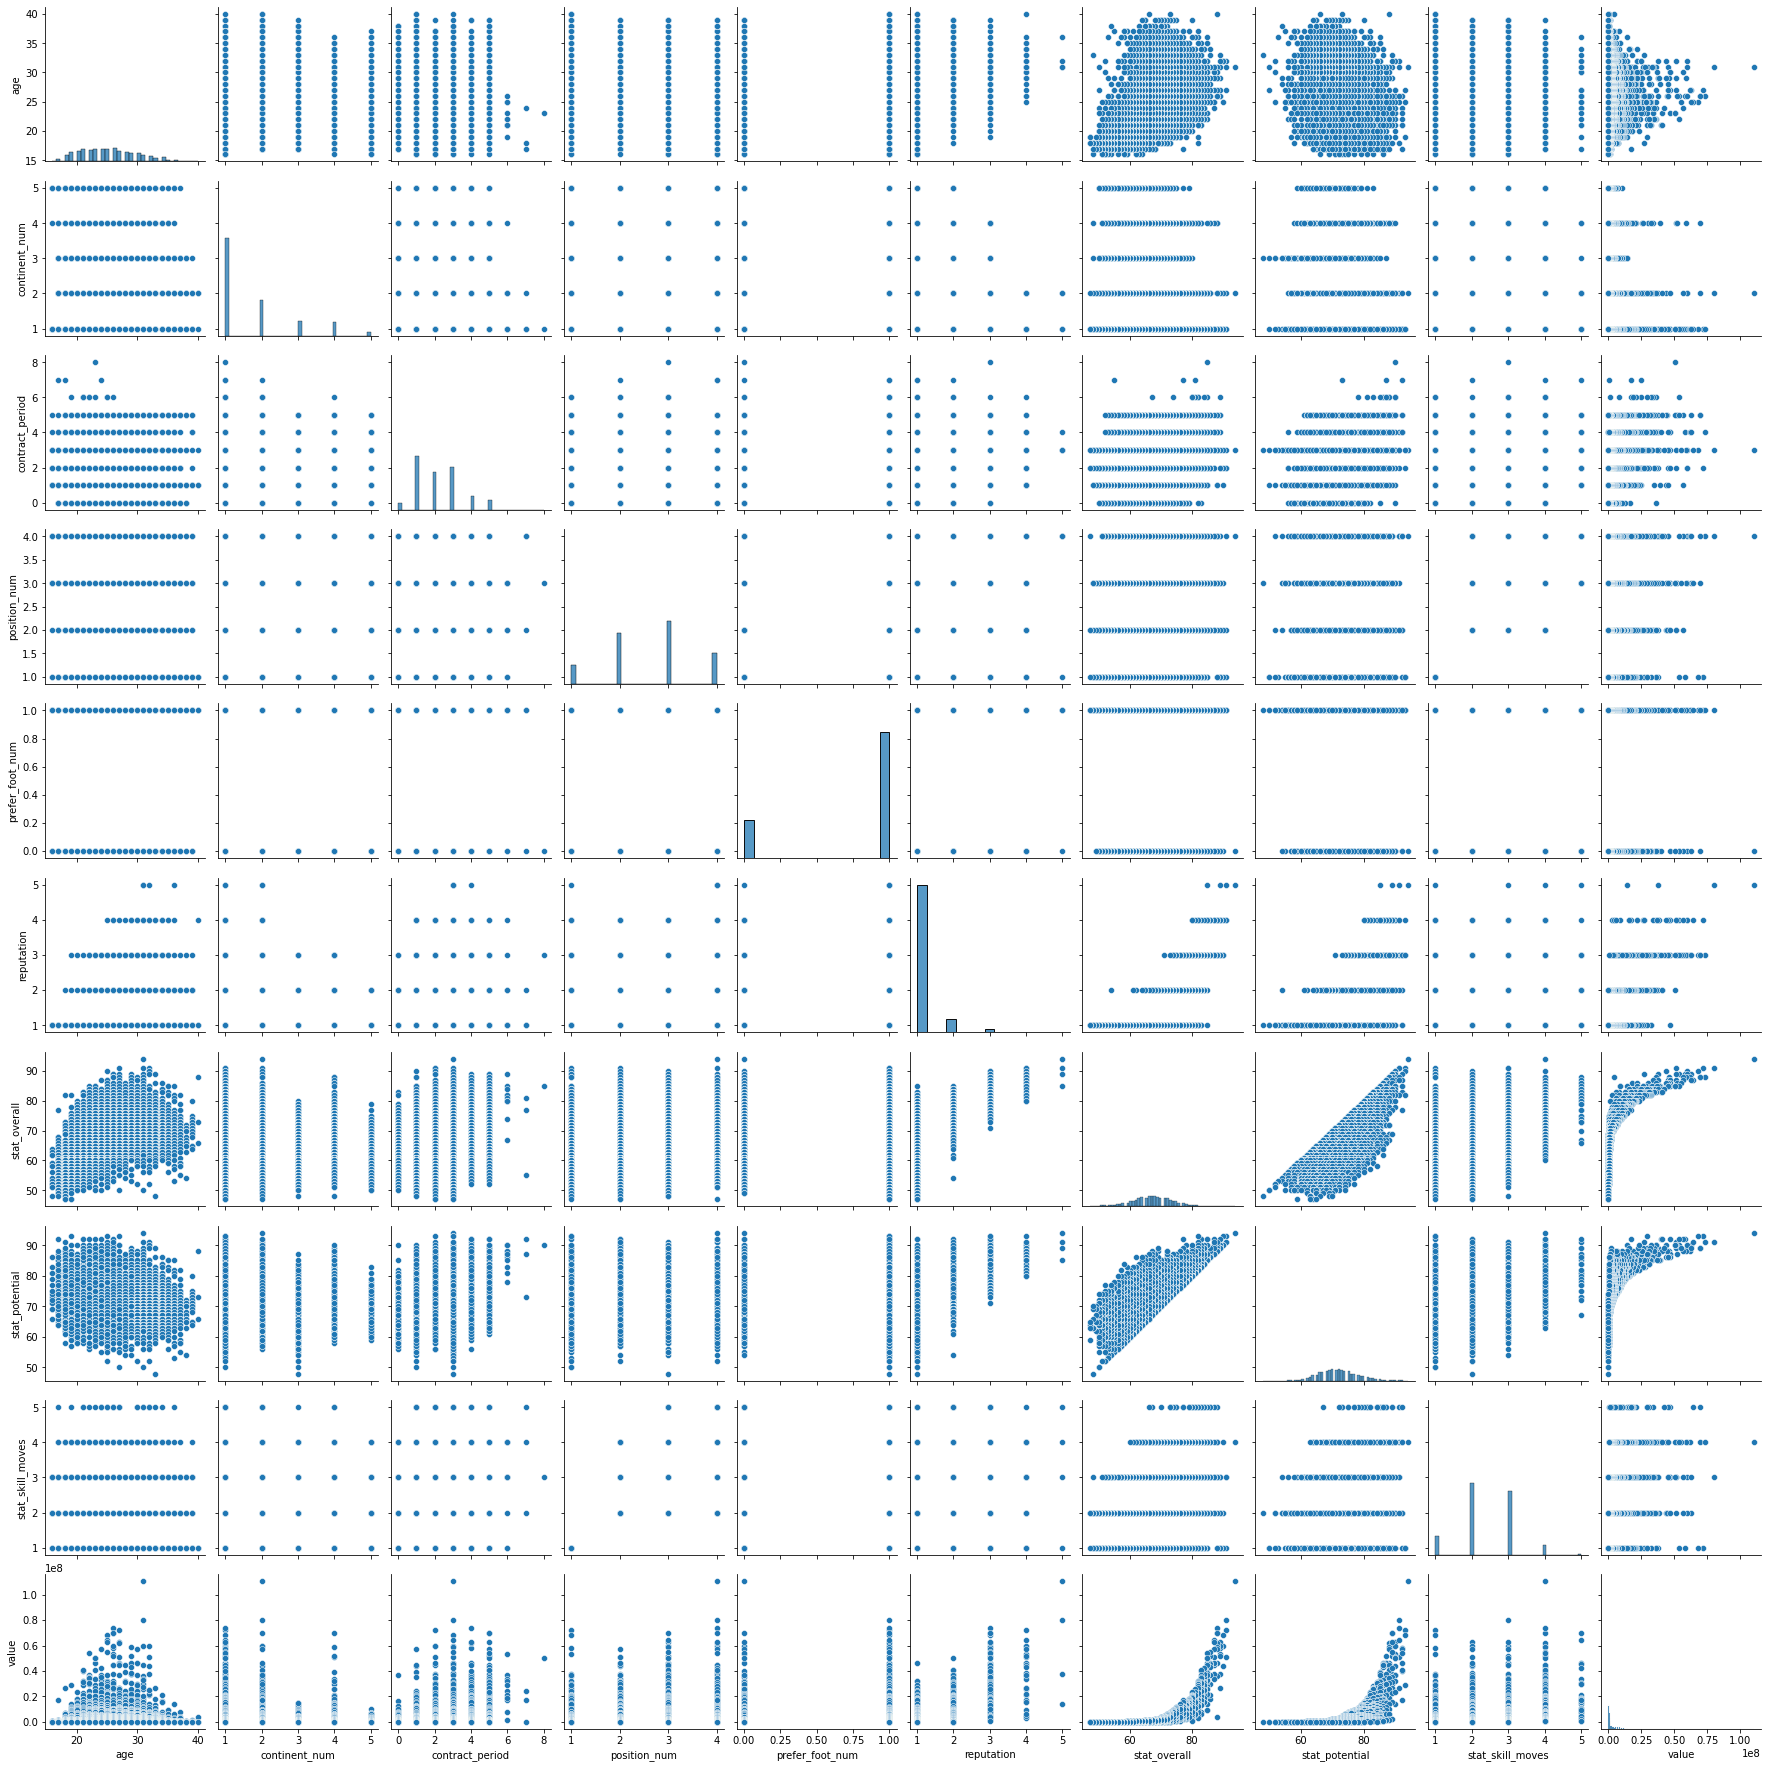

In [187]:
sns.pairplot(fifa_data)

1. stat_overall, stat_potential은 목적변수 value와 높은 상관관계가 있습니다. 선수가 능력치가 좋으면 당연히 몸값이 높아지기 때문입니다.
2. reputation도 목적변수 value와 높은 상관관계가 있습니다. 축구도 결국 비즈니스이기 때문입니다. 유명하고 명성있는 선수는 축구구단에게 많은 수익을 가져다오기 때문에, reputation도 value와 높은 상관성을 보일 수밖에 없습니다. 대표적인 예시가 작년 여름에 맨체스터 유나이티드로 이적하며 구단에 복귀하게 된 우리형 호날두입니다. 호날두의 이적 덕분에 맨유는 호날두의 유니폼 구입만으로도 호날두의 이적료를 채웠다고 합니다.
3. stat_overall과 stat_potential 서로에 대해서도 상관관계가 높다고 나왔습니다. 아무래도 현재 상황과 미래 발전 정도는 어느 정도 상관성이 있을 수 있기 때문입니다.

## 4. 파생변수 만들기

In [240]:
check_data.head()

age  continent_num  contract_period  position_num  prefer_foot_num  \
0   31              2                3             4                0   
1   27              1                2             1                1   
2   31              2                3             4                1   
3   32              1                2             2                1   
4   25              1                3             1                1   

   reputation  stat_overall  stat_potential  stat_skill_moves        value  \
0         5.0            94              94               4.0  110500000.0   
1         4.0            91              93               1.0   72000000.0   
2         5.0            91              91               3.0   80000000.0   
3         4.0            91              91               3.0   51000000.0   
4         3.0            90              93               1.0   68000000.0   

   stat_difference  
0                0  
1                2  
2                0  
3                0  
4                3

## 4.1. 연령대
- Age 변수를 활용해 10대, 20대, 30대, 40대 이상으로 나누었습니다.

In [241]:
def age_group_go(x):
    if x < 20:
        return '10_age_group'
    elif 20 <= x and x < 30:
        return '20_age_group'
    elif 30 <= x and x < 40:
        return '30_age_group'
    else:
        return '40_over_age_group'

In [242]:
check_data['age_group'] = check_data['age'].apply(age_group_go).astype('str')

<AxesSubplot:ylabel='age_group'>

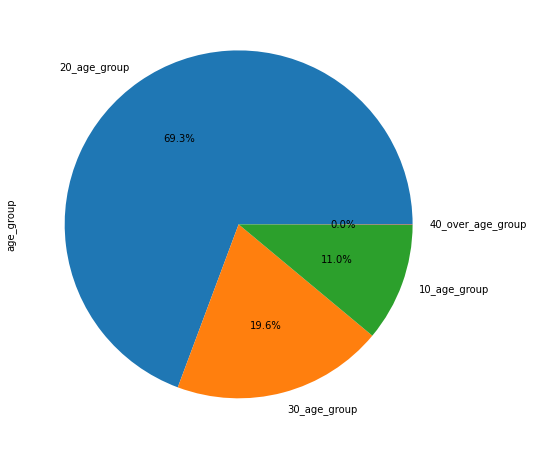

In [244]:
plt.figure(figsize=(12, 8))
check_data['age_group'].value_counts().plot.pie(autopct='%1.1f%%')

In [267]:
check_data['age_group'].value_counts()

20_age_group         6191
30_age_group         1754
10_age_group          984
40_over_age_group       3
Name: age_group, dtype: int64

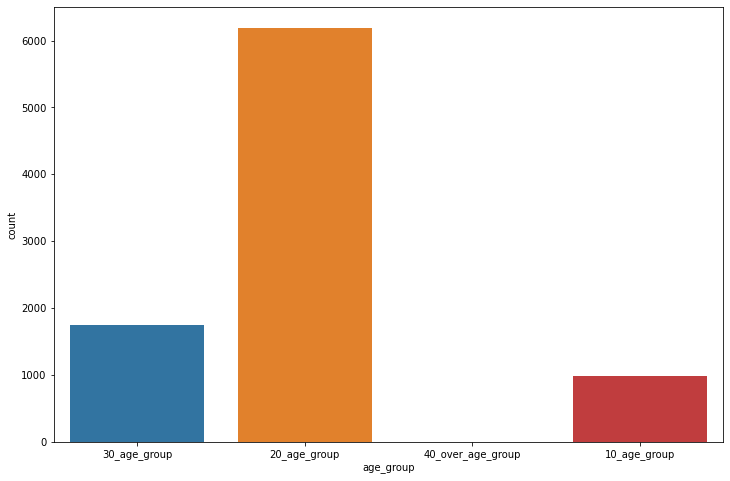

In [251]:
plt.figure(figsize=(12, 8))
sns.countplot(check_data['age_group'])
plt.show()

### 4.2. stat_overall 현재 능력치
- 50 미만, 능력치 50대, 60대, 70대, 80대, 90대로 분류

In [247]:
check_data['stat_overall'].describe()

count    8932.000000
mean       67.091133
std         6.854910
min        47.000000
25%        63.000000
50%        67.000000
75%        72.000000
max        94.000000
Name: stat_overall, dtype: float64

In [248]:
def stat_overall_go(x):
    if x < 50:
        return 'Under 50'
    elif 50 <= x and x < 60:
        return '50 overall'
    elif 60 <= x and x < 70:
        return '60 overall'
    elif 70 <= x and x < 80:
        return '70 overall'
    elif 80 <= x and x < 90:
        return '80 overall'
    else:
        return '90 overall'

In [249]:
check_data['stat_overall_group'] = check_data['stat_overall'].apply(stat_overall_go).astype('str')

<AxesSubplot:ylabel='stat_overall_group'>

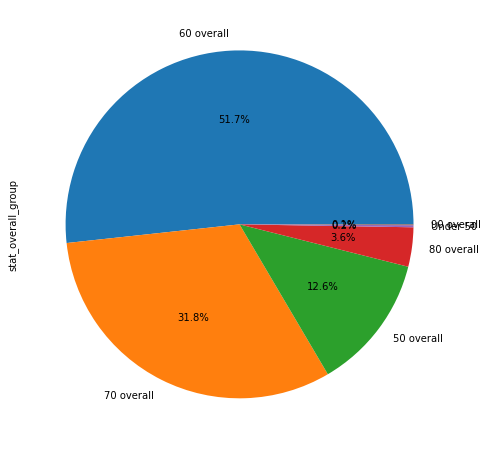

In [250]:
plt.figure(figsize=(12, 8))
check_data['stat_overall_group'].value_counts().plot.pie(autopct='%1.1f%%')

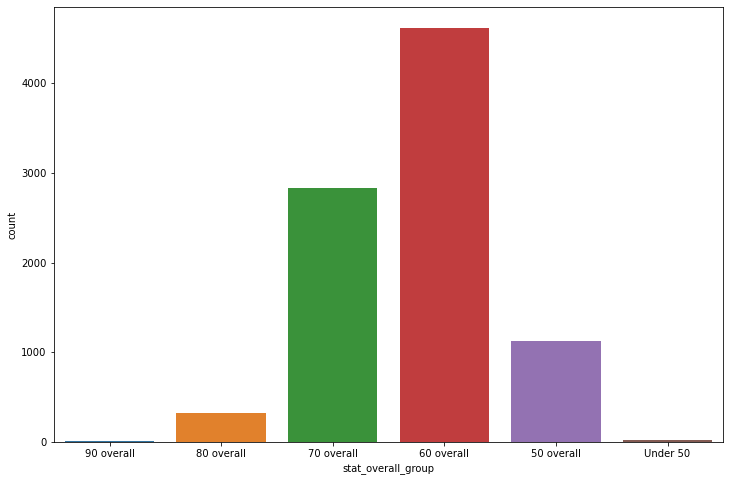

In [252]:
plt.figure(figsize=(12, 8))
sns.countplot(check_data['stat_overall_group'])
plt.show()

In [264]:
check_data['stat_overall_group'].value_counts()

60 overall    4619
70 overall    2837
50 overall    1126
80 overall     326
Under 50        17
90 overall       7
Name: stat_overall_group, dtype: int64

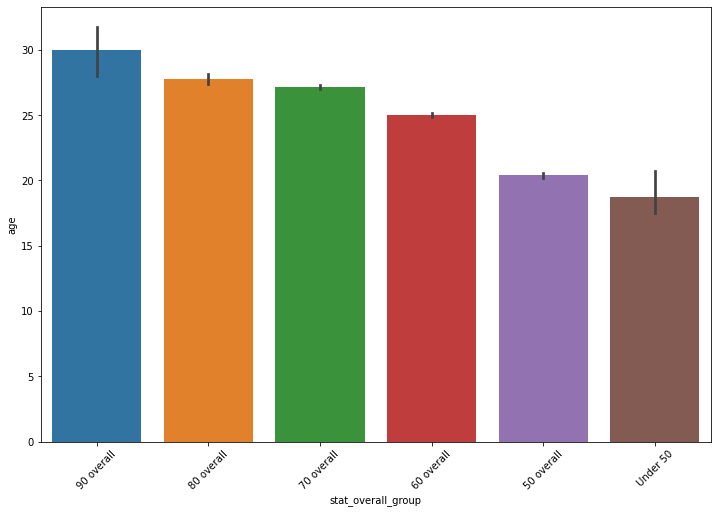

In [254]:
plt.figure(figsize=(12, 8))
g2 = sns.barplot(x=check_data['stat_overall_group'],y=check_data['age'])
plt.xticks(rotation=45)
plt.show()

### 4.3. stat_potential
- 50 미만, 능력치 50대, 60대, 70대, 80대, 90대로 분류

In [255]:
check_data['stat_potential'].describe()

count    8932.000000
mean       71.997201
std         5.988147
min        48.000000
25%        68.000000
50%        72.000000
75%        76.000000
max        94.000000
Name: stat_potential, dtype: float64

In [257]:
def stat_potential_go(x):
    if x < 50:
        return 'Under 50'
    elif 50 <= x and x < 60:
        return '50 potential'
    elif 60 <= x and x < 70:
        return '60 potential'
    elif 70 <= x and x < 80:
        return '70 potential'
    elif 80 <= x and x < 90:
        return '80 potential'
    else:
        return '90 potential'

In [258]:
check_data['stat_potential_group'] = check_data['stat_potential'].apply(stat_potential_go).astype('str')

<AxesSubplot:ylabel='stat_potential_group'>

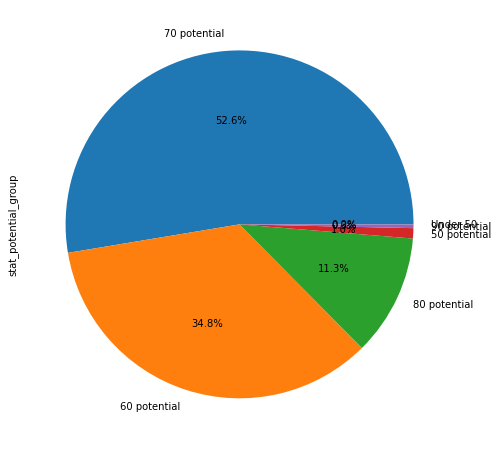

In [259]:
plt.figure(figsize=(12, 8))
check_data['stat_potential_group'].value_counts().plot.pie(autopct='%1.1f%%')

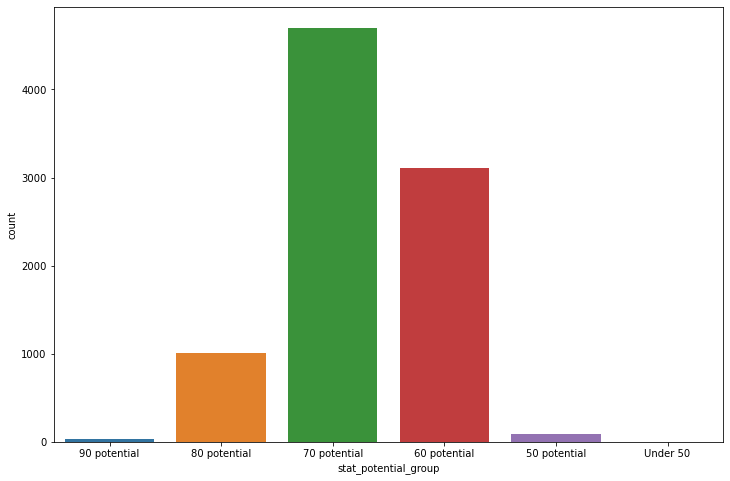

In [260]:
plt.figure(figsize=(12, 8))
sns.countplot(check_data['stat_potential_group'])
plt.show()

In [263]:
check_data['stat_potential_group'].value_counts()

70 potential    4700
60 potential    3108
80 potential    1008
50 potential      85
90 potential      30
Under 50           1
Name: stat_potential_group, dtype: int64

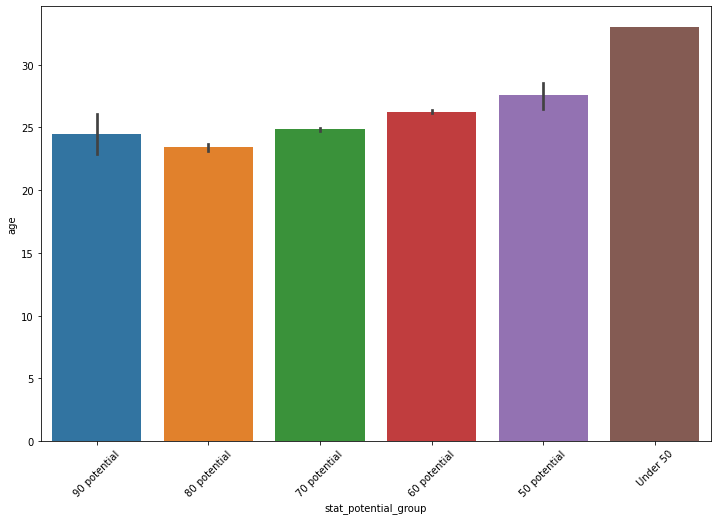

In [268]:
plt.figure(figsize=(12, 8))
g2 = sns.barplot(x=check_data['stat_potential_group'],y=check_data['age'])
plt.xticks(rotation=45)
plt.show()

## 5. 일반 회귀 모형

In [147]:
X = fifa_data.iloc[:, :-1]
y = fifa_data.iloc[:, -1]
X_n = X.to_numpy()

In [150]:
# random_state는 모두 17로 고정

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

lin_reg = LinearRegression()
svl = SVR(kernel='linear')
svr = SVR(kernel='rbf')

lin_reg.fit(X_train, y_train)
svl.fit(X_train, y_train)
svr.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)
y_pred_svl = svl.predict(X_test)
y_pred_svr = svr.predict(X_test)

In [152]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse_lin = mean_squared_error(y_test, y_pred_lin)
mse_svl = mean_squared_error(y_test, y_pred_svl)
mse_svr = mean_squared_error(y_test, y_pred_svr)

rmse_lin = np.sqrt(mse_lin)
rmse_svl = np.sqrt(mse_svl)
rmse_svr = np.sqrt(mse_svr)

print("RMSE for Linear Model : %.2f" % (rmse_lin))
print("RMSE for SVM with Linear Model : %.2f" % (rmse_svl))
print("RMSE for SVM with Rbf Model : %.2f" % (rmse_svr))

RMSE for Linear Model : 3755616.73
RMSE for SVM with Linear Model : 6006702.25
RMSE for SVM with Rbf Model : 6233795.40


## 6. Ensemble Learning

### XGBoost, LightGBM, Catboost를 활용한 회귀모형 구축

In [155]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

xg_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()
cat_reg = CatBoostRegressor()

xg_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
cat_reg.fit(X_train, y_train)

y_pred_xg = xg_reg.predict(X_test)
y_pred_lgb = lgbm_reg.predict(X_test)
y_pred_cat = cat_reg.predict(X_test)

mse_xg = mean_squared_error(y_test, y_pred_xg)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
mse_cat = mean_squared_error(y_test, y_pred_cat)

rmse_xg = np.sqrt(mse_xg)
rmse_lgb = np.sqrt(mse_lgb)
rmse_cat = np.sqrt(mse_cat)

print("RMSE for XGBoost : %.2f" % (rmse_xg))
print("RMSE for LGBM: %.2f" % (rmse_lgb))
print("RMSE for CatBoost: %.2f" % (rmse_cat))

Learning rate set to 0.055295
0:	learn: 5564527.0795895	total: 1.5ms	remaining: 1.5s
1:	learn: 5328596.8407023	total: 2.9ms	remaining: 1.45s
2:	learn: 5082075.7585315	total: 4.31ms	remaining: 1.43s
3:	learn: 4852839.3219164	total: 5.81ms	remaining: 1.45s
4:	learn: 4641744.3337285	total: 7.22ms	remaining: 1.44s
5:	learn: 4435778.4726149	total: 8.58ms	remaining: 1.42s
6:	learn: 4250914.8042907	total: 10ms	remaining: 1.42s
7:	learn: 4064891.1640629	total: 11.4ms	remaining: 1.41s
8:	learn: 3894096.5654461	total: 12.8ms	remaining: 1.41s
9:	learn: 3729798.3736663	total: 14.2ms	remaining: 1.41s
10:	learn: 3580319.3820578	total: 15.7ms	remaining: 1.41s
11:	learn: 3438579.2953659	total: 17ms	remaining: 1.4s
12:	learn: 3304493.6931951	total: 18.5ms	remaining: 1.41s
13:	learn: 3160889.2335712	total: 20ms	remaining: 1.41s
14:	learn: 3027936.7792697	total: 21.3ms	remaining: 1.4s
15:	learn: 2912658.5372875	total: 22.7ms	remaining: 1.4s
16:	learn: 2804361.6635340	total: 24.2ms	remaining: 1.4s
17:	lea

219:	learn: 332651.3701524	total: 324ms	remaining: 1.15s
220:	learn: 332583.2287990	total: 326ms	remaining: 1.15s
221:	learn: 331674.4305372	total: 327ms	remaining: 1.15s
222:	learn: 331609.1866770	total: 329ms	remaining: 1.15s
223:	learn: 330189.0813544	total: 330ms	remaining: 1.14s
224:	learn: 330127.2002204	total: 332ms	remaining: 1.14s
225:	learn: 328727.6734967	total: 333ms	remaining: 1.14s
226:	learn: 327527.2524132	total: 334ms	remaining: 1.14s
227:	learn: 326690.5919503	total: 336ms	remaining: 1.14s
228:	learn: 325580.3985026	total: 338ms	remaining: 1.14s
229:	learn: 324801.1039893	total: 340ms	remaining: 1.14s
230:	learn: 324743.2489181	total: 341ms	remaining: 1.14s
231:	learn: 323717.3301563	total: 343ms	remaining: 1.14s
232:	learn: 322825.6000743	total: 344ms	remaining: 1.13s
233:	learn: 322769.6540659	total: 346ms	remaining: 1.13s
234:	learn: 321700.4220616	total: 347ms	remaining: 1.13s
235:	learn: 320782.0618733	total: 348ms	remaining: 1.13s
236:	learn: 319737.2862876	tota

374:	learn: 253774.9998904	total: 645ms	remaining: 1.07s
375:	learn: 253630.7204577	total: 649ms	remaining: 1.08s
376:	learn: 253399.1157444	total: 651ms	remaining: 1.08s
377:	learn: 253077.2766543	total: 654ms	remaining: 1.08s
378:	learn: 252942.2687152	total: 656ms	remaining: 1.07s
379:	learn: 252672.6885156	total: 658ms	remaining: 1.07s
380:	learn: 252357.4140095	total: 661ms	remaining: 1.07s
381:	learn: 251689.5608224	total: 662ms	remaining: 1.07s
382:	learn: 251440.5498667	total: 664ms	remaining: 1.07s
383:	learn: 251228.9674512	total: 668ms	remaining: 1.07s
384:	learn: 250911.8382741	total: 671ms	remaining: 1.07s
385:	learn: 250702.3660531	total: 674ms	remaining: 1.07s
386:	learn: 250166.4102559	total: 677ms	remaining: 1.07s
387:	learn: 249656.3856168	total: 680ms	remaining: 1.07s
388:	learn: 249317.6825237	total: 684ms	remaining: 1.07s
389:	learn: 249041.1541879	total: 687ms	remaining: 1.07s
390:	learn: 248921.9246728	total: 688ms	remaining: 1.07s
391:	learn: 248815.0778919	tota

526:	learn: 219828.7099598	total: 968ms	remaining: 868ms
527:	learn: 219687.7603901	total: 970ms	remaining: 867ms
528:	learn: 219591.5033531	total: 971ms	remaining: 865ms
529:	learn: 219406.8729528	total: 973ms	remaining: 863ms
530:	learn: 219400.1391004	total: 974ms	remaining: 861ms
531:	learn: 219222.1093799	total: 976ms	remaining: 858ms
532:	learn: 219215.5488784	total: 977ms	remaining: 856ms
533:	learn: 219087.2017554	total: 978ms	remaining: 854ms
534:	learn: 218934.0307984	total: 980ms	remaining: 852ms
535:	learn: 218829.4088654	total: 982ms	remaining: 850ms
536:	learn: 218731.3166560	total: 983ms	remaining: 848ms
537:	learn: 218548.7180975	total: 985ms	remaining: 846ms
538:	learn: 218542.3856898	total: 986ms	remaining: 843ms
539:	learn: 218330.6801242	total: 988ms	remaining: 841ms
540:	learn: 218324.4806695	total: 989ms	remaining: 839ms
541:	learn: 218120.1908956	total: 991ms	remaining: 837ms
542:	learn: 217925.7754004	total: 993ms	remaining: 836ms
543:	learn: 217785.5833453	tota

737:	learn: 191729.2562797	total: 1.3s	remaining: 461ms
738:	learn: 191726.6558981	total: 1.3s	remaining: 459ms
739:	learn: 191588.0326302	total: 1.3s	remaining: 457ms
740:	learn: 191405.1975218	total: 1.3s	remaining: 456ms
741:	learn: 191235.1866431	total: 1.3s	remaining: 454ms
742:	learn: 191204.4088941	total: 1.31s	remaining: 452ms
743:	learn: 191035.7374361	total: 1.31s	remaining: 450ms
744:	learn: 190977.2697964	total: 1.31s	remaining: 449ms
745:	learn: 190867.4891944	total: 1.31s	remaining: 447ms
746:	learn: 190823.2157588	total: 1.31s	remaining: 445ms
747:	learn: 190702.3473328	total: 1.31s	remaining: 443ms
748:	learn: 190696.1043832	total: 1.32s	remaining: 441ms
749:	learn: 190653.1805646	total: 1.32s	remaining: 439ms
750:	learn: 190612.0543187	total: 1.32s	remaining: 437ms
751:	learn: 190505.1888263	total: 1.32s	remaining: 436ms
752:	learn: 190394.6606552	total: 1.32s	remaining: 434ms
753:	learn: 190355.4593958	total: 1.32s	remaining: 432ms
754:	learn: 190353.0995096	total: 1.

942:	learn: 172611.4707815	total: 1.63s	remaining: 98.6ms
943:	learn: 172509.3265848	total: 1.63s	remaining: 96.9ms
944:	learn: 172464.8509803	total: 1.64s	remaining: 95.2ms
945:	learn: 172346.4332458	total: 1.64s	remaining: 93.4ms
946:	learn: 172277.8172717	total: 1.64s	remaining: 91.7ms
947:	learn: 172183.1967152	total: 1.64s	remaining: 89.9ms
948:	learn: 172133.5450918	total: 1.64s	remaining: 88.2ms
949:	learn: 172036.6856052	total: 1.64s	remaining: 86.5ms
950:	learn: 171878.1416941	total: 1.64s	remaining: 84.7ms
951:	learn: 171793.8070425	total: 1.65s	remaining: 83ms
952:	learn: 171754.4873443	total: 1.65s	remaining: 81.3ms
953:	learn: 171718.3133257	total: 1.65s	remaining: 79.5ms
954:	learn: 171664.1058002	total: 1.65s	remaining: 77.8ms
955:	learn: 171611.7414936	total: 1.65s	remaining: 76.1ms
956:	learn: 171574.9229411	total: 1.65s	remaining: 74.4ms
957:	learn: 171511.8470682	total: 1.66s	remaining: 72.6ms
958:	learn: 171447.8472925	total: 1.66s	remaining: 70.9ms
959:	learn: 1714

### CatBoost를 활용한 회귀모형 구축

In [122]:
X = fifa_data.iloc[:, :-1]
y = fifa_data.iloc[:, -1]

In [123]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [124]:
X_n = X.to_numpy()

In [125]:
# !pip install catboost

import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

cat_reg = CatBoostRegressor()
cat_reg.fit(X_train, y_train)
y_pred_cat = cat_reg.predict(X_test)
mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mse_cat)

print("RMSE for Catboost : %.2f" % (rmse_cat))

Learning rate set to 0.054695
0:	learn: 5581270.9179404	total: 152ms	remaining: 2m 32s
1:	learn: 5358396.9927206	total: 154ms	remaining: 1m 16s
2:	learn: 5120932.0079306	total: 156ms	remaining: 51.8s
3:	learn: 4903505.7622887	total: 158ms	remaining: 39.2s
4:	learn: 4689278.4489095	total: 160ms	remaining: 31.8s
5:	learn: 4483793.6345870	total: 161ms	remaining: 26.7s
6:	learn: 4304516.1065672	total: 163ms	remaining: 23.1s
7:	learn: 4118727.5286650	total: 165ms	remaining: 20.5s
8:	learn: 3939743.0730236	total: 167ms	remaining: 18.3s
9:	learn: 3777527.0201788	total: 169ms	remaining: 16.7s
10:	learn: 3625808.4637229	total: 171ms	remaining: 15.3s
11:	learn: 3479179.7874388	total: 172ms	remaining: 14.2s
12:	learn: 3339775.6925555	total: 174ms	remaining: 13.2s
13:	learn: 3198352.3399222	total: 175ms	remaining: 12.3s
14:	learn: 3072397.8605292	total: 177ms	remaining: 11.6s
15:	learn: 2956763.1329046	total: 179ms	remaining: 11s
16:	learn: 2846998.3602722	total: 181ms	remaining: 10.4s
17:	learn: 

228:	learn: 326925.1014725	total: 502ms	remaining: 1.69s
229:	learn: 326863.2483516	total: 503ms	remaining: 1.68s
230:	learn: 326414.7952133	total: 505ms	remaining: 1.68s
231:	learn: 325129.1745413	total: 506ms	remaining: 1.68s
232:	learn: 324975.1582100	total: 507ms	remaining: 1.67s
233:	learn: 324056.4150594	total: 509ms	remaining: 1.67s
234:	learn: 322861.6702272	total: 510ms	remaining: 1.66s
235:	learn: 322691.5227476	total: 511ms	remaining: 1.66s
236:	learn: 322016.9135973	total: 513ms	remaining: 1.65s
237:	learn: 321961.3417785	total: 514ms	remaining: 1.65s
238:	learn: 320823.0084978	total: 516ms	remaining: 1.64s
239:	learn: 320385.0347405	total: 518ms	remaining: 1.64s
240:	learn: 319375.6317916	total: 520ms	remaining: 1.64s
241:	learn: 319323.4395089	total: 521ms	remaining: 1.63s
242:	learn: 319114.1147376	total: 523ms	remaining: 1.63s
243:	learn: 318310.1183626	total: 524ms	remaining: 1.62s
244:	learn: 317250.1728467	total: 525ms	remaining: 1.62s
245:	learn: 316451.0208726	tota

426:	learn: 242038.6686020	total: 829ms	remaining: 1.11s
427:	learn: 241755.7179107	total: 832ms	remaining: 1.11s
428:	learn: 241533.5516996	total: 834ms	remaining: 1.11s
429:	learn: 241266.2462728	total: 836ms	remaining: 1.11s
430:	learn: 240996.0946087	total: 838ms	remaining: 1.11s
431:	learn: 240668.2068957	total: 854ms	remaining: 1.12s
432:	learn: 240459.6042708	total: 856ms	remaining: 1.12s
433:	learn: 240351.5449792	total: 859ms	remaining: 1.12s
434:	learn: 240139.8507216	total: 862ms	remaining: 1.12s
435:	learn: 239833.3060559	total: 866ms	remaining: 1.12s
436:	learn: 239495.6416545	total: 870ms	remaining: 1.12s
437:	learn: 239224.1410951	total: 874ms	remaining: 1.12s
438:	learn: 238940.4620505	total: 879ms	remaining: 1.12s
439:	learn: 238745.6927676	total: 882ms	remaining: 1.12s
440:	learn: 238528.2020065	total: 885ms	remaining: 1.12s
441:	learn: 237937.0550261	total: 889ms	remaining: 1.12s
442:	learn: 237708.4352745	total: 890ms	remaining: 1.12s
443:	learn: 237154.9106371	tota

616:	learn: 201026.9439647	total: 1.15s	remaining: 716ms
617:	learn: 200912.9344793	total: 1.15s	remaining: 714ms
618:	learn: 200790.9127852	total: 1.16s	remaining: 711ms
619:	learn: 200570.9727427	total: 1.16s	remaining: 709ms
620:	learn: 200432.4811977	total: 1.16s	remaining: 707ms
621:	learn: 200340.7189379	total: 1.16s	remaining: 705ms
622:	learn: 200173.3418844	total: 1.16s	remaining: 703ms
623:	learn: 200046.9966290	total: 1.16s	remaining: 701ms
624:	learn: 199865.7978901	total: 1.16s	remaining: 698ms
625:	learn: 199744.5066701	total: 1.17s	remaining: 696ms
626:	learn: 199620.4807573	total: 1.17s	remaining: 694ms
627:	learn: 199450.4946726	total: 1.17s	remaining: 692ms
628:	learn: 199281.1836588	total: 1.17s	remaining: 690ms
629:	learn: 199156.1458516	total: 1.17s	remaining: 688ms
630:	learn: 199017.2503134	total: 1.17s	remaining: 686ms
631:	learn: 198936.6889352	total: 1.17s	remaining: 684ms
632:	learn: 198812.3457892	total: 1.18s	remaining: 682ms
633:	learn: 198659.7321183	tota

826:	learn: 182091.6904912	total: 1.49s	remaining: 311ms
827:	learn: 182088.1971379	total: 1.49s	remaining: 310ms
828:	learn: 182034.5865057	total: 1.49s	remaining: 308ms
829:	learn: 181853.9352380	total: 1.49s	remaining: 306ms
830:	learn: 181837.4715412	total: 1.5s	remaining: 304ms
831:	learn: 181822.5858771	total: 1.5s	remaining: 302ms
832:	learn: 181729.9723918	total: 1.5s	remaining: 300ms
833:	learn: 181639.4188171	total: 1.5s	remaining: 299ms
834:	learn: 181559.0373589	total: 1.5s	remaining: 297ms
835:	learn: 181467.0641058	total: 1.5s	remaining: 295ms
836:	learn: 181452.7693033	total: 1.5s	remaining: 293ms
837:	learn: 181388.5011070	total: 1.51s	remaining: 291ms
838:	learn: 181374.8909973	total: 1.51s	remaining: 289ms
839:	learn: 181314.2186949	total: 1.51s	remaining: 288ms
840:	learn: 181252.3520655	total: 1.51s	remaining: 286ms
841:	learn: 181149.3494417	total: 1.51s	remaining: 284ms
842:	learn: 181147.9089898	total: 1.51s	remaining: 282ms
843:	learn: 181146.5111707	total: 1.52

In [126]:
fifa_data['value'].describe()

count    8.932000e+03
mean     2.778673e+06
std      5.840982e+06
min      1.000000e+04
25%      3.750000e+05
50%      8.250000e+05
75%      2.600000e+06
max      1.105000e+08
Name: value, dtype: float64

- 5.840982e+06 == 5840982
- 5840982 // 2 == 2,920,491

- 선형회귀모형의 RMSE가 926590.65이므로 
- 예측오차가 위 출력에 기초하여 0.5σ 이내에 있어 어느 정도 신뢰도가 있는 선형회귀 모형임을 알 수 있다.

## 7. CatBoost에서의 Feature Importance 및 Partial Dependency 정의 후 적용

### 특성변수 중요도

In [127]:
cat_reg.feature_importances_

array([1.04420852e+01, 2.07340914e-01, 4.99307017e-01, 3.18047914e+00,
       5.76149651e-02, 1.29722042e-01, 6.82539161e+01, 1.51262163e+01,
       2.10331834e+00])

### 특성변수와 특성변수 중요도를 내림차순으로 정리

In [128]:
sorted_idx = np.argsort(cat_reg.feature_importances_)
sorted_col = X_train.columns[sorted_idx]
sorted_imp = cat_reg.feature_importances_[sorted_idx]
feature_dict = dict(zip(sorted_col, sorted_imp))
imp_cat = list(feature_dict.items())[::-1]
print(imp_cat)

[('stat_overall', 68.25391608947248), ('stat_potential', 15.126216285912639), ('age', 10.442085201482891), ('position_num', 3.180479144489302), ('stat_skill_moves', 2.1033183404620432), ('contract_period', 0.4993070170762592), ('continent_num', 0.2073409137003421), ('reputation', 0.12972204226372536), ('prefer_foot_num', 0.05761496514031508)]


In [129]:
print(len(imp_cat))

9


### 특성변수 중요도 plot 그리기

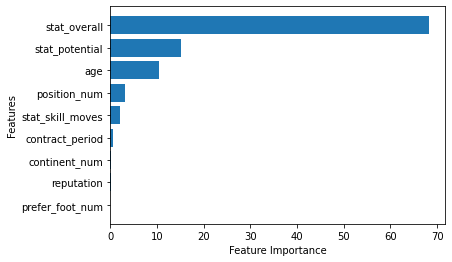

In [130]:
features = sorted_col[-9:]
feature_imp = sorted_imp[-9:]

import matplotlib.pyplot as plt

plt.barh(features, feature_imp)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

### 부분의존도 그리기

In [131]:
import numpy as np

def partial_dependency(model, X, features, f_id):
    X_temp = X.copy()
    grid = np.linspace(np.percentile(X_temp.iloc[:, f_id], 0.1),
                      np.percentile(X_temp.iloc[:, f_id], 99.5),
                      50)
    y_pred = np.zeros(len(grid))
    
    for i, val in enumerate(grid):
        X_temp.iloc[:, f_id] = val
        y_pred[i] = model.predict(X_temp.iloc[:, :features]).mean()
        
    return grid, y_pred

In [135]:
def partial_dependency_visualize(model, X, features, f_id):
    X_temp = X.copy()
    features = X_train.shape[1]
    grid = np.linspace(np.percentile(X_temp.iloc[:, f_id], 0.1),
                      np.percentile(X_temp.iloc[:, f_id], 99.5),
                      50)
    y_pred = np.zeros(len(grid))
    
    for i, val in enumerate(grid):
        X_temp.iloc[:, f_id] = val
        y_pred[i] = model.predict(X_temp.iloc[:, :features]).mean()
    
    print('-' * 80)
    print("f_id = %d" % (f_id))
    print(grid)
    print(y_pred)
    plt.plot(grid, y_pred)
    plt.xlabel(X_train.columns[f_id])
    plt.ylabel('Partial dependence')
    plt.show()    

--------------------------------------------------------------------------------
f_id = 0
[16.         16.42857143 16.85714286 17.28571429 17.71428571 18.14285714
 18.57142857 19.         19.42857143 19.85714286 20.28571429 20.71428571
 21.14285714 21.57142857 22.         22.42857143 22.85714286 23.28571429
 23.71428571 24.14285714 24.57142857 25.         25.42857143 25.85714286
 26.28571429 26.71428571 27.14285714 27.57142857 28.         28.42857143
 28.85714286 29.28571429 29.71428571 30.14285714 30.57142857 31.
 31.42857143 31.85714286 32.28571429 32.71428571 33.14285714 33.57142857
 34.         34.42857143 34.85714286 35.28571429 35.71428571 36.14285714
 36.57142857 37.        ]
[2985467.51076557 2985467.51076557 2985467.51076557 2985467.51076557
 3055626.12637945 3055626.12637945 3111841.60176169 3111841.60176169
 3111841.60176169 3135630.23806278 3135630.23806278 3146326.88585628
 3146326.88585628 3152200.86702965 3152200.86702965 3152200.86702965
 3155644.89792807 3155644.897928

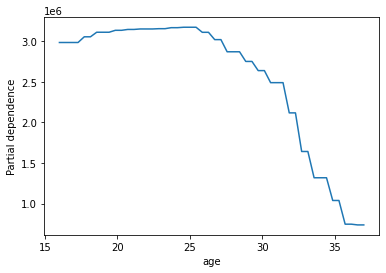

--------------------------------------------------------------------------------
f_id = 1
[1.         1.08163265 1.16326531 1.24489796 1.32653061 1.40816327
 1.48979592 1.57142857 1.65306122 1.73469388 1.81632653 1.89795918
 1.97959184 2.06122449 2.14285714 2.2244898  2.30612245 2.3877551
 2.46938776 2.55102041 2.63265306 2.71428571 2.79591837 2.87755102
 2.95918367 3.04081633 3.12244898 3.20408163 3.28571429 3.36734694
 3.44897959 3.53061224 3.6122449  3.69387755 3.7755102  3.85714286
 3.93877551 4.02040816 4.10204082 4.18367347 4.26530612 4.34693878
 4.42857143 4.51020408 4.59183673 4.67346939 4.75510204 4.83673469
 4.91836735 5.        ]
[2787916.27629419 2787916.27629419 2787916.27629419 2787916.27629419
 2787916.27629419 2787916.27629419 2787916.27629419 2773882.60397021
 2773882.60397021 2773882.60397021 2773882.60397021 2773882.60397021
 2773882.60397021 2773882.60397021 2773882.60397021 2773882.60397021
 2773882.60397021 2773882.60397021 2773882.60397021 2779527.55917597
 27795

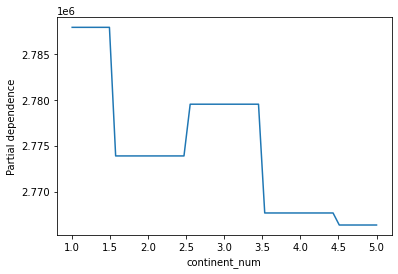

--------------------------------------------------------------------------------
f_id = 2
[0.         0.10204082 0.20408163 0.30612245 0.40816327 0.51020408
 0.6122449  0.71428571 0.81632653 0.91836735 1.02040816 1.12244898
 1.2244898  1.32653061 1.42857143 1.53061224 1.63265306 1.73469388
 1.83673469 1.93877551 2.04081633 2.14285714 2.24489796 2.34693878
 2.44897959 2.55102041 2.65306122 2.75510204 2.85714286 2.95918367
 3.06122449 3.16326531 3.26530612 3.36734694 3.46938776 3.57142857
 3.67346939 3.7755102  3.87755102 3.97959184 4.08163265 4.18367347
 4.28571429 4.3877551  4.48979592 4.59183673 4.69387755 4.79591837
 4.89795918 5.        ]
[2770056.97344361 2770056.97344361 2770056.97344361 2770056.97344361
 2770056.97344361 2769416.12976603 2769416.12976603 2769416.12976603
 2769416.12976603 2769416.12976603 2769416.12976603 2769416.12976603
 2769416.12976603 2769416.12976603 2769416.12976603 2781078.18912615
 2781078.18912615 2781078.18912615 2781078.18912615 2781078.18912615
 2781

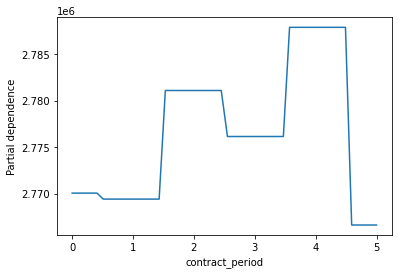

--------------------------------------------------------------------------------
f_id = 3
[1.         1.06122449 1.12244898 1.18367347 1.24489796 1.30612245
 1.36734694 1.42857143 1.48979592 1.55102041 1.6122449  1.67346939
 1.73469388 1.79591837 1.85714286 1.91836735 1.97959184 2.04081633
 2.10204082 2.16326531 2.2244898  2.28571429 2.34693878 2.40816327
 2.46938776 2.53061224 2.59183673 2.65306122 2.71428571 2.7755102
 2.83673469 2.89795918 2.95918367 3.02040816 3.08163265 3.14285714
 3.20408163 3.26530612 3.32653061 3.3877551  3.44897959 3.51020408
 3.57142857 3.63265306 3.69387755 3.75510204 3.81632653 3.87755102
 3.93877551 4.        ]
[2366320.89227063 2366320.89227063 2366320.89227063 2366320.89227063
 2366320.89227063 2366320.89227063 2366320.89227063 2366320.89227063
 2366320.89227063 2515906.74108538 2515906.74108538 2515906.74108538
 2515906.74108538 2515906.74108538 2515906.74108538 2515906.74108538
 2515906.74108538 2515906.74108538 2515906.74108538 2515906.74108538
 25159

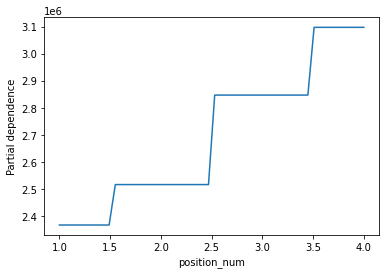

--------------------------------------------------------------------------------
f_id = 4
[0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
 0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
 0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
 0.97959184 1.        ]
[2774332.58306795 2774332.58306795 2774332.58306795 2774332.58306795
 2774332.58306795 2774332.58306795 2774332.58306795 2774332.58306795
 2774332.58306795 2774332.58306795 2774332.58306795 2774332.58306795
 2774332.58306795 2774332.58306795 2774332.58306795 2774332.58306795
 2774332.58306795 2774332.58306795 2774332.58306795 2774332.58306795
 27743

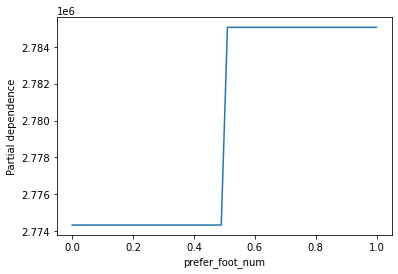

--------------------------------------------------------------------------------
f_id = 5
[1.         1.04081633 1.08163265 1.12244898 1.16326531 1.20408163
 1.24489796 1.28571429 1.32653061 1.36734694 1.40816327 1.44897959
 1.48979592 1.53061224 1.57142857 1.6122449  1.65306122 1.69387755
 1.73469388 1.7755102  1.81632653 1.85714286 1.89795918 1.93877551
 1.97959184 2.02040816 2.06122449 2.10204082 2.14285714 2.18367347
 2.2244898  2.26530612 2.30612245 2.34693878 2.3877551  2.42857143
 2.46938776 2.51020408 2.55102041 2.59183673 2.63265306 2.67346939
 2.71428571 2.75510204 2.79591837 2.83673469 2.87755102 2.91836735
 2.95918367 3.        ]
[2771608.54136897 2771608.54136897 2771608.54136897 2771608.54136897
 2771608.54136897 2771608.54136897 2771608.54136897 2771608.54136897
 2771608.54136897 2771608.54136897 2771608.54136897 2771608.54136897
 2771608.54136897 2794753.16822046 2794753.16822046 2794753.16822046
 2794753.16822046 2794753.16822046 2794753.16822046 2794753.16822046
 2794

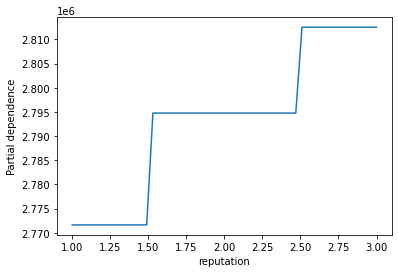

--------------------------------------------------------------------------------
f_id = 6
[48.         48.75510204 49.51020408 50.26530612 51.02040816 51.7755102
 52.53061224 53.28571429 54.04081633 54.79591837 55.55102041 56.30612245
 57.06122449 57.81632653 58.57142857 59.32653061 60.08163265 60.83673469
 61.59183673 62.34693878 63.10204082 63.85714286 64.6122449  65.36734694
 66.12244898 66.87755102 67.63265306 68.3877551  69.14285714 69.89795918
 70.65306122 71.40816327 72.16326531 72.91836735 73.67346939 74.42857143
 75.18367347 75.93877551 76.69387755 77.44897959 78.20408163 78.95918367
 79.71428571 80.46938776 81.2244898  81.97959184 82.73469388 83.48979592
 84.24489796 85.        ]
[  224135.99236232   224135.99236232   224135.99236232   224135.99236232
   224135.99236232   231041.18913115   240558.87284213   240558.87284213
   240558.87284213   258687.48913722   258687.48913722   258687.48913722
   258687.48913722   288882.91725179   312629.06034071   312629.06034071
   376053

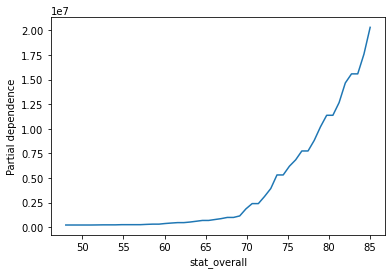

--------------------------------------------------------------------------------
f_id = 7
[53.251      53.98057143 54.71014286 55.43971429 56.16928571 56.89885714
 57.62842857 58.358      59.08757143 59.81714286 60.54671429 61.27628571
 62.00585714 62.73542857 63.465      64.19457143 64.92414286 65.65371429
 66.38328571 67.11285714 67.84242857 68.572      69.30157143 70.03114286
 70.76071429 71.49028571 72.21985714 72.94942857 73.679      74.40857143
 75.13814286 75.86771429 76.59728571 77.32685714 78.05642857 78.786
 79.51557143 80.24514286 80.97471429 81.70428571 82.43385714 83.16342857
 83.893      84.62257143 85.35214286 86.08171429 86.81128571 87.54085714
 88.27042857 89.        ]
[2004468.26117165 2004468.26117165 2004468.26117165 2004468.26117165
 2004468.26117165 2004468.26117165 2004468.26117165 2004468.26117165
 2004468.26117165 2004468.26117165 2004468.26117165 2004468.26117165
 2004468.26117165 2004468.26117165 2004468.26117165 2078364.77123041
 2078364.77123041 2086347.156

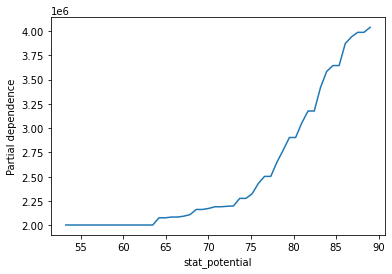

--------------------------------------------------------------------------------
f_id = 8
[1.         1.06122449 1.12244898 1.18367347 1.24489796 1.30612245
 1.36734694 1.42857143 1.48979592 1.55102041 1.6122449  1.67346939
 1.73469388 1.79591837 1.85714286 1.91836735 1.97959184 2.04081633
 2.10204082 2.16326531 2.2244898  2.28571429 2.34693878 2.40816327
 2.46938776 2.53061224 2.59183673 2.65306122 2.71428571 2.7755102
 2.83673469 2.89795918 2.95918367 3.02040816 3.08163265 3.14285714
 3.20408163 3.26530612 3.32653061 3.3877551  3.44897959 3.51020408
 3.57142857 3.63265306 3.69387755 3.75510204 3.81632653 3.87755102
 3.93877551 4.        ]
[2585982.59028432 2585982.59028432 2585982.59028432 2585982.59028432
 2585982.59028432 2585982.59028432 2585982.59028432 2585982.59028432
 2585982.59028432 2655305.96650818 2655305.96650818 2655305.96650818
 2655305.96650818 2655305.96650818 2655305.96650818 2655305.96650818
 2655305.96650818 2655305.96650818 2655305.96650818 2655305.96650818
 26553

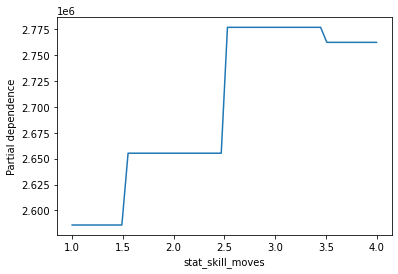

In [136]:
for i in range(9):
    partial_dependency_visualize(cat_reg, X_train, features, i)

- 위에서 for문을 돌리며 모든 특성변수들의 부분의즌도를 자동으로 구했지만, 설명을 위해 하나씩 다시 코드를 실행해보며 설명을 진행해보겠다. 

--------------------------------------------------------------------------------
f_id = 0
[16.         16.42857143 16.85714286 17.28571429 17.71428571 18.14285714
 18.57142857 19.         19.42857143 19.85714286 20.28571429 20.71428571
 21.14285714 21.57142857 22.         22.42857143 22.85714286 23.28571429
 23.71428571 24.14285714 24.57142857 25.         25.42857143 25.85714286
 26.28571429 26.71428571 27.14285714 27.57142857 28.         28.42857143
 28.85714286 29.28571429 29.71428571 30.14285714 30.57142857 31.
 31.42857143 31.85714286 32.28571429 32.71428571 33.14285714 33.57142857
 34.         34.42857143 34.85714286 35.28571429 35.71428571 36.14285714
 36.57142857 37.        ]
[2985467.51076557 2985467.51076557 2985467.51076557 2985467.51076557
 3055626.12637945 3055626.12637945 3111841.60176169 3111841.60176169
 3111841.60176169 3135630.23806278 3135630.23806278 3146326.88585628
 3146326.88585628 3152200.86702965 3152200.86702965 3152200.86702965
 3155644.89792807 3155644.897928

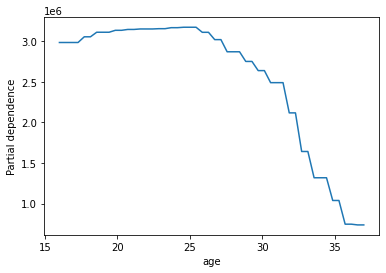

In [137]:
partial_dependency_visualize(cat_reg, X_train, features, 0)

- 선수의 나이(age)는 젊을수록 목적변수에 많은 영향을 끼친다는 모습을 보이고 있다. 20대 중후반부터 부분의존도가 감소하여 30대 중반이 되면 거의 0에 근접한다는 사실을 파악할 수 있다. 보통 축구선수의 전성기가 20대 중반과 후반이며, 30대 초반에 노쇠화를 겪고 30대 중반에 선수 은퇴를 하게 된다는 경향을 고려하면 이치에 맞는 부분의존도 그래프를 보이고 있다고 할 수 있겠다.

--------------------------------------------------------------------------------
f_id = 1
[1.         1.08163265 1.16326531 1.24489796 1.32653061 1.40816327
 1.48979592 1.57142857 1.65306122 1.73469388 1.81632653 1.89795918
 1.97959184 2.06122449 2.14285714 2.2244898  2.30612245 2.3877551
 2.46938776 2.55102041 2.63265306 2.71428571 2.79591837 2.87755102
 2.95918367 3.04081633 3.12244898 3.20408163 3.28571429 3.36734694
 3.44897959 3.53061224 3.6122449  3.69387755 3.7755102  3.85714286
 3.93877551 4.02040816 4.10204082 4.18367347 4.26530612 4.34693878
 4.42857143 4.51020408 4.59183673 4.67346939 4.75510204 4.83673469
 4.91836735 5.        ]
[2787916.27629419 2787916.27629419 2787916.27629419 2787916.27629419
 2787916.27629419 2787916.27629419 2787916.27629419 2773882.60397021
 2773882.60397021 2773882.60397021 2773882.60397021 2773882.60397021
 2773882.60397021 2773882.60397021 2773882.60397021 2773882.60397021
 2773882.60397021 2773882.60397021 2773882.60397021 2779527.55917597
 27795

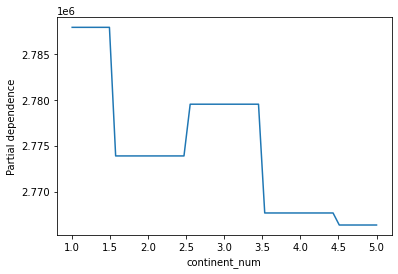

In [138]:
partial_dependency_visualize(cat_reg, X_train, features, 1)

- continent_num 변수는 Feature Importance가, 중요도가 1미만의 수치로 도출되어 목적변수에 그렇게 많은 영향을 끼치지는 않는다. (위로 올라가서 Feature Importance 그래프 참조)

--------------------------------------------------------------------------------
f_id = 2
[0.         0.10204082 0.20408163 0.30612245 0.40816327 0.51020408
 0.6122449  0.71428571 0.81632653 0.91836735 1.02040816 1.12244898
 1.2244898  1.32653061 1.42857143 1.53061224 1.63265306 1.73469388
 1.83673469 1.93877551 2.04081633 2.14285714 2.24489796 2.34693878
 2.44897959 2.55102041 2.65306122 2.75510204 2.85714286 2.95918367
 3.06122449 3.16326531 3.26530612 3.36734694 3.46938776 3.57142857
 3.67346939 3.7755102  3.87755102 3.97959184 4.08163265 4.18367347
 4.28571429 4.3877551  4.48979592 4.59183673 4.69387755 4.79591837
 4.89795918 5.        ]
[2770056.97344361 2770056.97344361 2770056.97344361 2770056.97344361
 2770056.97344361 2769416.12976603 2769416.12976603 2769416.12976603
 2769416.12976603 2769416.12976603 2769416.12976603 2769416.12976603
 2769416.12976603 2769416.12976603 2769416.12976603 2781078.18912615
 2781078.18912615 2781078.18912615 2781078.18912615 2781078.18912615
 2781

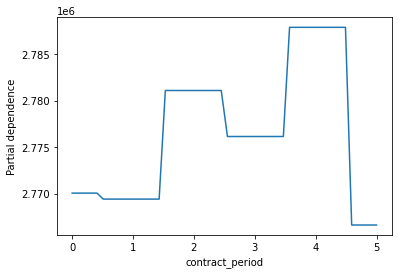

In [139]:
partial_dependency_visualize(cat_reg, X_train, features, 2)

- 계약기간의 경우, 계약기간의 연도에서 본 데이터의 시점인 2018년을 뺀 수치이기 때문에 모두 정수로 표현되어 있다. 구체적인 데이터 요약 정보로는 min=0, Q1=1.0, Q2=2.0, Q3=3.0, max=8.0, mean=2.19이다. Q3가 3.0이고 평균값이 2.19인 것을 보아 대부분의 축구선수들의 계약기간이 3년 이하라는 사실을 확인할 수 있다. 그럼에도 불구하고 contract_period 변수의 부분의존도 그래프를 보면, 축구선수의 계약기간이 4년이 남은 경우가 목적변수에 가장 많은 영향을 끼치는 모습을 보이고 있다. 이후 계약기간 2년, 3년, 1년 이하, 5년 이상의 순서로 목적변수에 대한 영향도가 있다. 
- 이를 통해, 계약기간이 많다고, 혹은 너무 적다고 이적료가 높아지는 것이 아니라, 적절한 계약기간이 선수의 이적료를 높이는데 많은 영향을 끼친다는 점을 파악할 수 있다.

--------------------------------------------------------------------------------
f_id = 3
[1.         1.06122449 1.12244898 1.18367347 1.24489796 1.30612245
 1.36734694 1.42857143 1.48979592 1.55102041 1.6122449  1.67346939
 1.73469388 1.79591837 1.85714286 1.91836735 1.97959184 2.04081633
 2.10204082 2.16326531 2.2244898  2.28571429 2.34693878 2.40816327
 2.46938776 2.53061224 2.59183673 2.65306122 2.71428571 2.7755102
 2.83673469 2.89795918 2.95918367 3.02040816 3.08163265 3.14285714
 3.20408163 3.26530612 3.32653061 3.3877551  3.44897959 3.51020408
 3.57142857 3.63265306 3.69387755 3.75510204 3.81632653 3.87755102
 3.93877551 4.        ]
[2366320.89227063 2366320.89227063 2366320.89227063 2366320.89227063
 2366320.89227063 2366320.89227063 2366320.89227063 2366320.89227063
 2366320.89227063 2515906.74108538 2515906.74108538 2515906.74108538
 2515906.74108538 2515906.74108538 2515906.74108538 2515906.74108538
 2515906.74108538 2515906.74108538 2515906.74108538 2515906.74108538
 25159

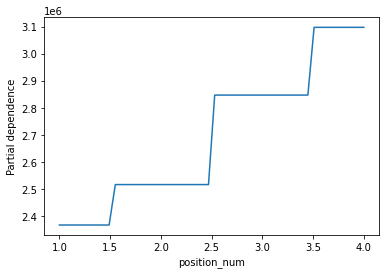

In [140]:
partial_dependency_visualize(cat_reg, X_train, features, 3)

- position_num 부분의존도 그래프의 경우 계단 형식을 보이고 있는데, 1이 골키퍼(GK), 2가 수비수(DF), 3이 미드필더(MF), 4가 공격수(ST)라는 사실을 고려해야 한다. 이는 대체로 득점에 직접적으로 관여하는 공격수와 미드필더의 몸값이 수비수와 골키퍼보다 높다는 것을 보여준다. 
- 이러한 사안은 세계 최고의 축구선수에게 주어지는 상인 프랑스 풋볼의 ’발롱도르(Ballon d'Or)‘에서도 확인할 수 있는데, 1956년부터 2021년까지의 역대 발롱도르 수상자 중 독일의 수비수 프란츠 베켄바워(1972, 1976년), 이탈리아의 수비수 파비오 칸나바로(2006년)등 극히 일부를 제외하고는 크리스티아누 호날두(이하 호날두)와 리오넬 메시 등 95% 이상의 발롱도르 수상자가 공격수와 미드필더라는 점이다. 
- 이처럼 축구는 주로 공격수와 미드필더에게 많은 관심이 쏟아지는 경향이 있다고 할 수 있겠다.

--------------------------------------------------------------------------------
f_id = 4
[0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
 0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
 0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
 0.97959184 1.        ]
[2774332.58306795 2774332.58306795 2774332.58306795 2774332.58306795
 2774332.58306795 2774332.58306795 2774332.58306795 2774332.58306795
 2774332.58306795 2774332.58306795 2774332.58306795 2774332.58306795
 2774332.58306795 2774332.58306795 2774332.58306795 2774332.58306795
 2774332.58306795 2774332.58306795 2774332.58306795 2774332.58306795
 27743

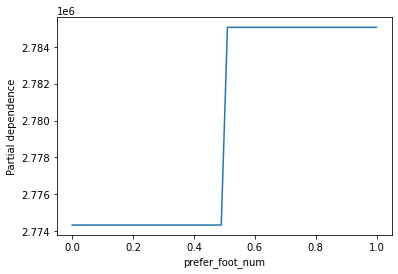

In [141]:
partial_dependency_visualize(cat_reg, X_train, features, 4)

- prefer_foot_num에서는 0이 왼발을, 1이 오른발이라는 사실을 인지해야 한다. 왼발보다 오른발이 주발인 선수의 이적료가 높다는 것을 확인할 수 있다.
- 다만, 내가 이 FIFA 데이터에서 한 가지 아쉬운 점이 있는데, 그것은 바로 선수의 주발을 오로지 왼발과 오른발이라는 2분할적인 시각에서 바라보았다는 점이다. 요즘 같은 시대에는 축구선수들의 경쟁이 격화됨에 따라 양발잡이인 선수가 많은 호응을 받고 있기 때문이다.
- 물론 prefer_foot 변수는 선수가 선호하는 발을 나타낸 변수이기 때문에 양발잡이라고 하더라도 둘 중에 어떤 발을 선호하는지를 나타냈다고도 할 수 있겠다. 하지만 양발잡이 선수라면 선수의 몸값은 당연히 상승하기 때문에 ‘both_footed’라는 새로운 변수를 추가하면 어떨까 싶다. 해당 변수에 One-Hot Encoding 방식을 채택하여, 왼발과 오른발 모두 최고 평점인 5점을 받은 양발잡이 선수에 한해서는 1을, 양발잡이 선수가 아니라면 0을 기입하는 것이다. 이렇게 된다면 both_footed 변수는 세계 최정상급 선수들 중에서도 최고 레벨의 선수로 판가름하는 하나의 기준이 될 수 있을 것이라고 기대한다.

--------------------------------------------------------------------------------
f_id = 5
[1.         1.04081633 1.08163265 1.12244898 1.16326531 1.20408163
 1.24489796 1.28571429 1.32653061 1.36734694 1.40816327 1.44897959
 1.48979592 1.53061224 1.57142857 1.6122449  1.65306122 1.69387755
 1.73469388 1.7755102  1.81632653 1.85714286 1.89795918 1.93877551
 1.97959184 2.02040816 2.06122449 2.10204082 2.14285714 2.18367347
 2.2244898  2.26530612 2.30612245 2.34693878 2.3877551  2.42857143
 2.46938776 2.51020408 2.55102041 2.59183673 2.63265306 2.67346939
 2.71428571 2.75510204 2.79591837 2.83673469 2.87755102 2.91836735
 2.95918367 3.        ]
[2771608.54136897 2771608.54136897 2771608.54136897 2771608.54136897
 2771608.54136897 2771608.54136897 2771608.54136897 2771608.54136897
 2771608.54136897 2771608.54136897 2771608.54136897 2771608.54136897
 2771608.54136897 2794753.16822046 2794753.16822046 2794753.16822046
 2794753.16822046 2794753.16822046 2794753.16822046 2794753.16822046
 2794

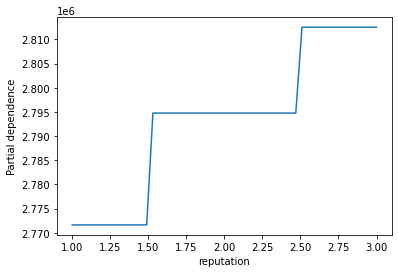

In [142]:
partial_dependency_visualize(cat_reg, X_train, features, 5)

- 선수의 명성이 높을수록 이적료에 영향을 끼친다는 사실을 알 수 있다.
- 계단 형식으로 도출되었다.

--------------------------------------------------------------------------------
f_id = 6
[48.         48.75510204 49.51020408 50.26530612 51.02040816 51.7755102
 52.53061224 53.28571429 54.04081633 54.79591837 55.55102041 56.30612245
 57.06122449 57.81632653 58.57142857 59.32653061 60.08163265 60.83673469
 61.59183673 62.34693878 63.10204082 63.85714286 64.6122449  65.36734694
 66.12244898 66.87755102 67.63265306 68.3877551  69.14285714 69.89795918
 70.65306122 71.40816327 72.16326531 72.91836735 73.67346939 74.42857143
 75.18367347 75.93877551 76.69387755 77.44897959 78.20408163 78.95918367
 79.71428571 80.46938776 81.2244898  81.97959184 82.73469388 83.48979592
 84.24489796 85.        ]
[  224135.99236232   224135.99236232   224135.99236232   224135.99236232
   224135.99236232   231041.18913115   240558.87284213   240558.87284213
   240558.87284213   258687.48913722   258687.48913722   258687.48913722
   258687.48913722   288882.91725179   312629.06034071   312629.06034071
   376053

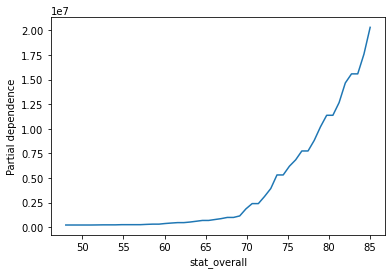

In [143]:
partial_dependency_visualize(cat_reg, X_train, features, 6)

- stat_overall 변수는 변수의 값이 증가함에 따라 지수함수와 유사한 형식으로 목적변수에 영향을 끼치는 모습을 보이고 있다. 
- 특히, stat_overall 부분의존도 그래프의 y축 단위는 타 특성변수 부분의존도 그래프의 y축 단위가 모두 1e6인 것과 다르게 유일하게 1e7이라는 점에 주목해야 한다.

--------------------------------------------------------------------------------
f_id = 7
[53.251      53.98057143 54.71014286 55.43971429 56.16928571 56.89885714
 57.62842857 58.358      59.08757143 59.81714286 60.54671429 61.27628571
 62.00585714 62.73542857 63.465      64.19457143 64.92414286 65.65371429
 66.38328571 67.11285714 67.84242857 68.572      69.30157143 70.03114286
 70.76071429 71.49028571 72.21985714 72.94942857 73.679      74.40857143
 75.13814286 75.86771429 76.59728571 77.32685714 78.05642857 78.786
 79.51557143 80.24514286 80.97471429 81.70428571 82.43385714 83.16342857
 83.893      84.62257143 85.35214286 86.08171429 86.81128571 87.54085714
 88.27042857 89.        ]
[2004468.26117165 2004468.26117165 2004468.26117165 2004468.26117165
 2004468.26117165 2004468.26117165 2004468.26117165 2004468.26117165
 2004468.26117165 2004468.26117165 2004468.26117165 2004468.26117165
 2004468.26117165 2004468.26117165 2004468.26117165 2078364.77123041
 2078364.77123041 2086347.156

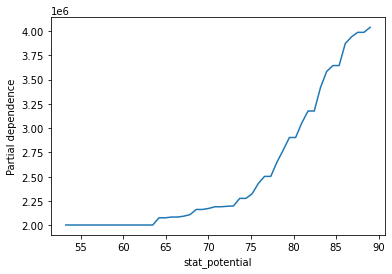

In [144]:
partial_dependency_visualize(cat_reg, X_train, features, 7)

- stat_potential 변수 역시 stat_overall 변수와 마찬가지로 지수함수와 유사한 형식을 보이고 있다.

--------------------------------------------------------------------------------
f_id = 8
[1.         1.06122449 1.12244898 1.18367347 1.24489796 1.30612245
 1.36734694 1.42857143 1.48979592 1.55102041 1.6122449  1.67346939
 1.73469388 1.79591837 1.85714286 1.91836735 1.97959184 2.04081633
 2.10204082 2.16326531 2.2244898  2.28571429 2.34693878 2.40816327
 2.46938776 2.53061224 2.59183673 2.65306122 2.71428571 2.7755102
 2.83673469 2.89795918 2.95918367 3.02040816 3.08163265 3.14285714
 3.20408163 3.26530612 3.32653061 3.3877551  3.44897959 3.51020408
 3.57142857 3.63265306 3.69387755 3.75510204 3.81632653 3.87755102
 3.93877551 4.        ]
[2585982.59028432 2585982.59028432 2585982.59028432 2585982.59028432
 2585982.59028432 2585982.59028432 2585982.59028432 2585982.59028432
 2585982.59028432 2655305.96650818 2655305.96650818 2655305.96650818
 2655305.96650818 2655305.96650818 2655305.96650818 2655305.96650818
 2655305.96650818 2655305.96650818 2655305.96650818 2655305.96650818
 26553

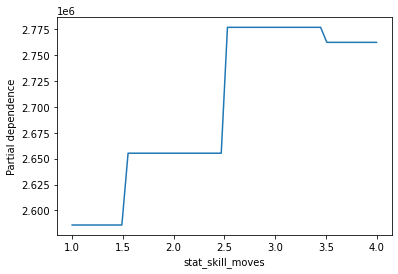

In [145]:
partial_dependency_visualize(cat_reg, X_train, features, 8)

- stat_skill_moves의 Feature Importance가 2.10인 것을 제외하고는 모두 중요도가 1 미만의 수치로 도출되어 목적변수에 그렇게 많은 영향을 끼치지는 않는다. 그래도 각 특성변수마다의 부분의존도를 도출해봄으로써 그 성질을 파악해보았다.

## 8. Cross-Validation
- 실제적인 모형 성능의 비교를 위한 교차 검증

### cv = 10

In [156]:
from sklearn.model_selection import cross_val_score

cat_reg = CatBoostRegressor()
scores_cat = cross_val_score(cat_reg, X, y, scoring='neg_mean_squared_error', cv=10)
rmse_cat = np.sqrt(-scores_cat)
print('Cat RMSE:', np.round(rmse_cat, 2))
print('Cat_RMSE mean: %.2f' % (rmse_cat.mean()))

Learning rate set to 0.056911
0:	learn: 1701141.2257308	total: 2.87ms	remaining: 2.86s
1:	learn: 1618959.4977237	total: 4.88ms	remaining: 2.44s
2:	learn: 1535844.6735731	total: 8ms	remaining: 2.66s
3:	learn: 1460101.0378185	total: 10.2ms	remaining: 2.55s
4:	learn: 1388905.1452748	total: 11.8ms	remaining: 2.36s
5:	learn: 1320911.5232541	total: 13.4ms	remaining: 2.22s
6:	learn: 1255931.1508955	total: 15.5ms	remaining: 2.2s
7:	learn: 1199093.7940315	total: 17ms	remaining: 2.11s
8:	learn: 1139929.5659222	total: 18.6ms	remaining: 2.04s
9:	learn: 1084917.8661331	total: 20.4ms	remaining: 2.02s
10:	learn: 1033433.8001851	total: 22ms	remaining: 1.98s
11:	learn: 985257.2285964	total: 23.5ms	remaining: 1.93s
12:	learn: 939462.8510614	total: 24.9ms	remaining: 1.89s
13:	learn: 895843.5211108	total: 26.4ms	remaining: 1.86s
14:	learn: 853977.3527041	total: 28.1ms	remaining: 1.85s
15:	learn: 815225.4279502	total: 29.8ms	remaining: 1.83s
16:	learn: 778666.7175236	total: 31.4ms	remaining: 1.82s
17:	lear

214:	learn: 115109.7839823	total: 335ms	remaining: 1.22s
215:	learn: 114912.7499821	total: 337ms	remaining: 1.22s
216:	learn: 114768.1528861	total: 339ms	remaining: 1.22s
217:	learn: 114720.2538262	total: 340ms	remaining: 1.22s
218:	learn: 114639.4410029	total: 342ms	remaining: 1.22s
219:	learn: 114560.4687956	total: 343ms	remaining: 1.22s
220:	learn: 114488.9196274	total: 344ms	remaining: 1.21s
221:	learn: 114404.2964663	total: 346ms	remaining: 1.21s
222:	learn: 114281.2842880	total: 348ms	remaining: 1.21s
223:	learn: 114131.8793378	total: 349ms	remaining: 1.21s
224:	learn: 114026.0087841	total: 351ms	remaining: 1.21s
225:	learn: 113916.9147748	total: 353ms	remaining: 1.21s
226:	learn: 113842.2429578	total: 355ms	remaining: 1.21s
227:	learn: 113770.2046270	total: 357ms	remaining: 1.21s
228:	learn: 113714.0090401	total: 359ms	remaining: 1.21s
229:	learn: 113647.2930766	total: 360ms	remaining: 1.21s
230:	learn: 113561.2516470	total: 362ms	remaining: 1.2s
231:	learn: 113483.9191530	total

434:	learn: 102182.5973997	total: 673ms	remaining: 874ms
435:	learn: 102115.6284504	total: 675ms	remaining: 873ms
436:	learn: 102066.0248373	total: 676ms	remaining: 872ms
437:	learn: 102027.2991234	total: 678ms	remaining: 870ms
438:	learn: 101968.1199544	total: 680ms	remaining: 869ms
439:	learn: 101930.4020360	total: 682ms	remaining: 867ms
440:	learn: 101886.9137297	total: 683ms	remaining: 866ms
441:	learn: 101850.3621687	total: 685ms	remaining: 865ms
442:	learn: 101798.7068642	total: 686ms	remaining: 863ms
443:	learn: 101766.6676401	total: 688ms	remaining: 862ms
444:	learn: 101721.5299664	total: 691ms	remaining: 861ms
445:	learn: 101676.3885089	total: 692ms	remaining: 860ms
446:	learn: 101629.5425249	total: 694ms	remaining: 858ms
447:	learn: 101615.5610297	total: 695ms	remaining: 857ms
448:	learn: 101593.8358647	total: 697ms	remaining: 855ms
449:	learn: 101538.4548588	total: 698ms	remaining: 854ms
450:	learn: 101515.7575154	total: 700ms	remaining: 852ms
451:	learn: 101483.0708851	tota

601:	learn: 96309.8927879	total: 1s	remaining: 664ms
602:	learn: 96261.9391585	total: 1.01s	remaining: 664ms
603:	learn: 96224.5587024	total: 1.01s	remaining: 662ms
604:	learn: 96204.4216892	total: 1.01s	remaining: 661ms
605:	learn: 96181.0773690	total: 1.01s	remaining: 660ms
606:	learn: 96167.1138605	total: 1.02s	remaining: 659ms
607:	learn: 96147.7263872	total: 1.02s	remaining: 658ms
608:	learn: 96078.2982076	total: 1.02s	remaining: 657ms
609:	learn: 96032.0814596	total: 1.02s	remaining: 656ms
610:	learn: 95960.1096311	total: 1.03s	remaining: 655ms
611:	learn: 95950.6017450	total: 1.03s	remaining: 654ms
612:	learn: 95885.1758341	total: 1.03s	remaining: 653ms
613:	learn: 95869.6491290	total: 1.04s	remaining: 652ms
614:	learn: 95850.9557174	total: 1.04s	remaining: 652ms
615:	learn: 95833.1618352	total: 1.04s	remaining: 650ms
616:	learn: 95819.6882996	total: 1.04s	remaining: 648ms
617:	learn: 95812.3832641	total: 1.05s	remaining: 647ms
618:	learn: 95789.8253215	total: 1.05s	remaining: 6

783:	learn: 91909.3347628	total: 1.33s	remaining: 368ms
784:	learn: 91878.7027244	total: 1.34s	remaining: 366ms
785:	learn: 91872.8184349	total: 1.34s	remaining: 364ms
786:	learn: 91844.4877809	total: 1.34s	remaining: 362ms
787:	learn: 91838.5483240	total: 1.34s	remaining: 361ms
788:	learn: 91825.8610793	total: 1.34s	remaining: 359ms
789:	learn: 91814.0212345	total: 1.34s	remaining: 357ms
790:	learn: 91792.7804825	total: 1.34s	remaining: 355ms
791:	learn: 91766.6029405	total: 1.35s	remaining: 354ms
792:	learn: 91740.1199652	total: 1.35s	remaining: 352ms
793:	learn: 91683.8026854	total: 1.35s	remaining: 350ms
794:	learn: 91669.0978921	total: 1.35s	remaining: 348ms
795:	learn: 91649.6743776	total: 1.35s	remaining: 347ms
796:	learn: 91622.2531226	total: 1.35s	remaining: 345ms
797:	learn: 91607.3223059	total: 1.36s	remaining: 343ms
798:	learn: 91597.9048096	total: 1.36s	remaining: 342ms
799:	learn: 91589.1004606	total: 1.36s	remaining: 340ms
800:	learn: 91576.1138476	total: 1.36s	remaining

972:	learn: 88888.9821287	total: 1.67s	remaining: 46.3ms
973:	learn: 88879.0928032	total: 1.67s	remaining: 44.6ms
974:	learn: 88866.8911240	total: 1.67s	remaining: 42.9ms
975:	learn: 88866.5807899	total: 1.67s	remaining: 41.2ms
976:	learn: 88855.6808919	total: 1.68s	remaining: 39.5ms
977:	learn: 88851.0596602	total: 1.68s	remaining: 37.7ms
978:	learn: 88850.8604628	total: 1.68s	remaining: 36ms
979:	learn: 88836.5570586	total: 1.68s	remaining: 34.3ms
980:	learn: 88826.6521050	total: 1.68s	remaining: 32.6ms
981:	learn: 88818.2378793	total: 1.68s	remaining: 30.9ms
982:	learn: 88798.2573775	total: 1.69s	remaining: 29.2ms
983:	learn: 88793.0864157	total: 1.69s	remaining: 27.4ms
984:	learn: 88778.0327380	total: 1.69s	remaining: 25.7ms
985:	learn: 88769.2180625	total: 1.69s	remaining: 24ms
986:	learn: 88732.2187813	total: 1.69s	remaining: 22.3ms
987:	learn: 88719.7702855	total: 1.7s	remaining: 20.6ms
988:	learn: 88710.6774069	total: 1.7s	remaining: 18.9ms
989:	learn: 88678.6213389	total: 1.7s

140:	learn: 490405.0923003	total: 235ms	remaining: 1.43s
141:	learn: 484472.2579322	total: 237ms	remaining: 1.43s
142:	learn: 483725.3812324	total: 239ms	remaining: 1.43s
143:	learn: 479322.0001032	total: 241ms	remaining: 1.43s
144:	learn: 478417.2034523	total: 242ms	remaining: 1.43s
145:	learn: 477022.8734894	total: 244ms	remaining: 1.43s
146:	learn: 476594.1741301	total: 245ms	remaining: 1.42s
147:	learn: 475822.6775809	total: 247ms	remaining: 1.42s
148:	learn: 475124.5519321	total: 249ms	remaining: 1.42s
149:	learn: 470089.3138499	total: 251ms	remaining: 1.42s
150:	learn: 469539.6248691	total: 252ms	remaining: 1.42s
151:	learn: 464546.2658296	total: 254ms	remaining: 1.41s
152:	learn: 461815.5736509	total: 255ms	remaining: 1.41s
153:	learn: 457339.6063402	total: 258ms	remaining: 1.41s
154:	learn: 453430.0579724	total: 260ms	remaining: 1.42s
155:	learn: 452434.6982142	total: 262ms	remaining: 1.42s
156:	learn: 450853.9192854	total: 264ms	remaining: 1.42s
157:	learn: 448350.1796618	tota

308:	learn: 302710.3581951	total: 554ms	remaining: 1.24s
309:	learn: 302030.6877669	total: 555ms	remaining: 1.24s
310:	learn: 301351.7521965	total: 557ms	remaining: 1.23s
311:	learn: 300797.0004436	total: 558ms	remaining: 1.23s
312:	learn: 299966.2862079	total: 560ms	remaining: 1.23s
313:	learn: 299044.9344817	total: 562ms	remaining: 1.23s
314:	learn: 298390.2472858	total: 563ms	remaining: 1.22s
315:	learn: 298075.5639337	total: 565ms	remaining: 1.22s
316:	learn: 297481.1039289	total: 566ms	remaining: 1.22s
317:	learn: 297146.1575557	total: 568ms	remaining: 1.22s
318:	learn: 296808.3435313	total: 570ms	remaining: 1.22s
319:	learn: 295920.4549607	total: 571ms	remaining: 1.21s
320:	learn: 295305.9940076	total: 573ms	remaining: 1.21s
321:	learn: 294694.6041384	total: 575ms	remaining: 1.21s
322:	learn: 293902.0570398	total: 577ms	remaining: 1.21s
323:	learn: 293534.9974345	total: 578ms	remaining: 1.21s
324:	learn: 293100.7609236	total: 580ms	remaining: 1.21s
325:	learn: 292556.5320612	tota

525:	learn: 224550.4985994	total: 894ms	remaining: 805ms
526:	learn: 224351.8418705	total: 896ms	remaining: 804ms
527:	learn: 224059.5348901	total: 898ms	remaining: 802ms
528:	learn: 223883.3641994	total: 899ms	remaining: 801ms
529:	learn: 223698.5978148	total: 901ms	remaining: 799ms
530:	learn: 223456.4316155	total: 902ms	remaining: 797ms
531:	learn: 223236.9480939	total: 904ms	remaining: 795ms
532:	learn: 223008.4554508	total: 905ms	remaining: 793ms
533:	learn: 222726.3151633	total: 907ms	remaining: 791ms
534:	learn: 222383.9516264	total: 909ms	remaining: 790ms
535:	learn: 222186.3716026	total: 910ms	remaining: 788ms
536:	learn: 221973.5840298	total: 912ms	remaining: 786ms
537:	learn: 221747.3867303	total: 913ms	remaining: 784ms
538:	learn: 221626.7032122	total: 915ms	remaining: 783ms
539:	learn: 221471.6042938	total: 917ms	remaining: 781ms
540:	learn: 221219.4334015	total: 919ms	remaining: 779ms
541:	learn: 220973.6982801	total: 921ms	remaining: 778ms
542:	learn: 220787.4646828	tota

737:	learn: 194509.9579440	total: 1.23s	remaining: 437ms
738:	learn: 194443.1399293	total: 1.23s	remaining: 435ms
739:	learn: 194240.4426935	total: 1.23s	remaining: 433ms
740:	learn: 194147.9433116	total: 1.24s	remaining: 432ms
741:	learn: 193878.1426715	total: 1.24s	remaining: 430ms
742:	learn: 193630.2487329	total: 1.24s	remaining: 428ms
743:	learn: 193493.8808736	total: 1.24s	remaining: 427ms
744:	learn: 193454.4342041	total: 1.24s	remaining: 425ms
745:	learn: 193381.2218285	total: 1.24s	remaining: 423ms
746:	learn: 193312.4923939	total: 1.24s	remaining: 422ms
747:	learn: 193218.5439360	total: 1.25s	remaining: 420ms
748:	learn: 193172.2150910	total: 1.25s	remaining: 418ms
749:	learn: 193055.1489660	total: 1.25s	remaining: 417ms
750:	learn: 192945.1441414	total: 1.25s	remaining: 415ms
751:	learn: 192765.4596228	total: 1.25s	remaining: 413ms
752:	learn: 192654.1775543	total: 1.25s	remaining: 412ms
753:	learn: 192568.5517514	total: 1.26s	remaining: 410ms
754:	learn: 192488.9598665	tota

954:	learn: 172773.5413345	total: 1.56s	remaining: 73.8ms
955:	learn: 172614.2327805	total: 1.57s	remaining: 72.1ms
956:	learn: 172550.7087446	total: 1.57s	remaining: 70.5ms
957:	learn: 172479.9524220	total: 1.57s	remaining: 68.9ms
958:	learn: 172330.7004918	total: 1.57s	remaining: 67.2ms
959:	learn: 172253.0661452	total: 1.57s	remaining: 65.6ms
960:	learn: 172203.9392852	total: 1.57s	remaining: 63.9ms
961:	learn: 172150.5250034	total: 1.58s	remaining: 62.3ms
962:	learn: 172076.3550262	total: 1.58s	remaining: 60.6ms
963:	learn: 171994.2273236	total: 1.58s	remaining: 59ms
964:	learn: 171854.1228158	total: 1.58s	remaining: 57.3ms
965:	learn: 171780.7569524	total: 1.58s	remaining: 55.7ms
966:	learn: 171673.8823213	total: 1.58s	remaining: 54ms
967:	learn: 171639.3698430	total: 1.58s	remaining: 52.4ms
968:	learn: 171597.6772911	total: 1.59s	remaining: 50.8ms
969:	learn: 171548.5955868	total: 1.59s	remaining: 49.1ms
970:	learn: 171510.3525350	total: 1.59s	remaining: 47.5ms
971:	learn: 171400

122:	learn: 547913.2930537	total: 193ms	remaining: 1.37s
123:	learn: 544395.0913063	total: 195ms	remaining: 1.38s
124:	learn: 543657.4035796	total: 196ms	remaining: 1.37s
125:	learn: 541298.3291330	total: 197ms	remaining: 1.37s
126:	learn: 535540.7352917	total: 199ms	remaining: 1.37s
127:	learn: 532050.7256016	total: 201ms	remaining: 1.37s
128:	learn: 530878.3589532	total: 202ms	remaining: 1.37s
129:	learn: 529971.9830528	total: 204ms	remaining: 1.36s
130:	learn: 529308.8630134	total: 205ms	remaining: 1.36s
131:	learn: 528328.9669867	total: 207ms	remaining: 1.36s
132:	learn: 525422.4385528	total: 209ms	remaining: 1.36s
133:	learn: 520309.8977993	total: 211ms	remaining: 1.36s
134:	learn: 519472.3534140	total: 212ms	remaining: 1.36s
135:	learn: 518573.9013952	total: 221ms	remaining: 1.41s
136:	learn: 516131.2780926	total: 223ms	remaining: 1.41s
137:	learn: 511541.0605515	total: 225ms	remaining: 1.4s
138:	learn: 510778.9370515	total: 226ms	remaining: 1.4s
139:	learn: 510116.8894803	total:

350:	learn: 293209.3478932	total: 533ms	remaining: 986ms
351:	learn: 292621.0730207	total: 535ms	remaining: 985ms
352:	learn: 292178.8704021	total: 537ms	remaining: 984ms
353:	learn: 291705.3580438	total: 538ms	remaining: 983ms
354:	learn: 291579.6121283	total: 540ms	remaining: 981ms
355:	learn: 291082.0956585	total: 541ms	remaining: 979ms
356:	learn: 289990.3046656	total: 543ms	remaining: 978ms
357:	learn: 289663.8300055	total: 544ms	remaining: 976ms
358:	learn: 289318.8122763	total: 546ms	remaining: 975ms
359:	learn: 288927.6289630	total: 547ms	remaining: 973ms
360:	learn: 288460.3332607	total: 549ms	remaining: 972ms
361:	learn: 288148.1269028	total: 551ms	remaining: 971ms
362:	learn: 287771.1178821	total: 553ms	remaining: 970ms
363:	learn: 287065.7284988	total: 555ms	remaining: 969ms
364:	learn: 286780.4515659	total: 556ms	remaining: 967ms
365:	learn: 286471.5025942	total: 557ms	remaining: 966ms
366:	learn: 286054.3082088	total: 559ms	remaining: 964ms
367:	learn: 285142.4080431	tota

541:	learn: 235594.6722540	total: 900ms	remaining: 761ms
542:	learn: 235382.7590477	total: 902ms	remaining: 759ms
543:	learn: 235240.7954607	total: 904ms	remaining: 757ms
544:	learn: 235104.0556687	total: 906ms	remaining: 756ms
545:	learn: 234826.9689259	total: 908ms	remaining: 755ms
546:	learn: 234539.0515211	total: 910ms	remaining: 753ms
547:	learn: 234427.9878724	total: 911ms	remaining: 752ms
548:	learn: 234246.3526719	total: 913ms	remaining: 750ms
549:	learn: 233999.1424281	total: 915ms	remaining: 749ms
550:	learn: 233803.9232044	total: 918ms	remaining: 748ms
551:	learn: 233635.4058330	total: 919ms	remaining: 746ms
552:	learn: 233407.3998453	total: 921ms	remaining: 745ms
553:	learn: 233150.0139550	total: 928ms	remaining: 747ms
554:	learn: 232900.2131808	total: 930ms	remaining: 746ms
555:	learn: 232708.3079617	total: 932ms	remaining: 744ms
556:	learn: 232552.1223490	total: 934ms	remaining: 743ms
557:	learn: 232389.8251543	total: 935ms	remaining: 741ms
558:	learn: 232216.1573621	tota

738:	learn: 208635.1643899	total: 1.24s	remaining: 437ms
739:	learn: 208573.9979579	total: 1.24s	remaining: 436ms
740:	learn: 208471.3984459	total: 1.24s	remaining: 434ms
741:	learn: 208343.0928911	total: 1.24s	remaining: 432ms
742:	learn: 208220.0540261	total: 1.25s	remaining: 431ms
743:	learn: 208103.6302318	total: 1.25s	remaining: 431ms
744:	learn: 208005.8045470	total: 1.25s	remaining: 429ms
745:	learn: 208002.8761538	total: 1.25s	remaining: 427ms
746:	learn: 207946.8227321	total: 1.26s	remaining: 426ms
747:	learn: 207768.9607705	total: 1.26s	remaining: 424ms
748:	learn: 207626.3859324	total: 1.26s	remaining: 423ms
749:	learn: 207598.1765951	total: 1.26s	remaining: 421ms
750:	learn: 207544.0518531	total: 1.26s	remaining: 419ms
751:	learn: 207541.6282283	total: 1.26s	remaining: 417ms
752:	learn: 207494.0305517	total: 1.27s	remaining: 416ms
753:	learn: 207437.0421224	total: 1.27s	remaining: 414ms
754:	learn: 207386.4840840	total: 1.27s	remaining: 412ms
755:	learn: 207367.8874511	tota

904:	learn: 193418.7088663	total: 1.57s	remaining: 165ms
905:	learn: 193120.9472940	total: 1.57s	remaining: 163ms
906:	learn: 193078.9103470	total: 1.57s	remaining: 161ms
907:	learn: 193020.0534352	total: 1.58s	remaining: 160ms
908:	learn: 192975.8846134	total: 1.58s	remaining: 158ms
909:	learn: 192947.3853165	total: 1.58s	remaining: 157ms
910:	learn: 192903.1861845	total: 1.58s	remaining: 155ms
911:	learn: 192830.5870410	total: 1.59s	remaining: 153ms
912:	learn: 192771.9069007	total: 1.59s	remaining: 151ms
913:	learn: 192727.9378760	total: 1.59s	remaining: 150ms
914:	learn: 192704.7911009	total: 1.59s	remaining: 148ms
915:	learn: 192685.9408799	total: 1.6s	remaining: 146ms
916:	learn: 192604.6129118	total: 1.6s	remaining: 145ms
917:	learn: 192586.5681284	total: 1.6s	remaining: 143ms
918:	learn: 192320.3780301	total: 1.6s	remaining: 141ms
919:	learn: 192238.2953356	total: 1.6s	remaining: 140ms
920:	learn: 192161.5497014	total: 1.61s	remaining: 138ms
921:	learn: 192046.6441666	total: 1.

53:	learn: 936145.5075359	total: 93.9ms	remaining: 1.65s
54:	learn: 931480.0805559	total: 95.3ms	remaining: 1.64s
55:	learn: 910370.6154788	total: 96.7ms	remaining: 1.63s
56:	learn: 905620.4845447	total: 98ms	remaining: 1.62s
57:	learn: 900776.2610572	total: 100ms	remaining: 1.63s
58:	learn: 896246.7075740	total: 102ms	remaining: 1.62s
59:	learn: 891565.3802473	total: 103ms	remaining: 1.62s
60:	learn: 887680.8473747	total: 105ms	remaining: 1.61s
61:	learn: 883452.5463811	total: 106ms	remaining: 1.6s
62:	learn: 879560.2630946	total: 107ms	remaining: 1.59s
63:	learn: 863725.6213871	total: 108ms	remaining: 1.58s
64:	learn: 846205.6575508	total: 111ms	remaining: 1.59s
65:	learn: 842495.9900502	total: 112ms	remaining: 1.58s
66:	learn: 838723.6362840	total: 113ms	remaining: 1.57s
67:	learn: 823080.3121659	total: 116ms	remaining: 1.6s
68:	learn: 819599.9144692	total: 118ms	remaining: 1.59s
69:	learn: 815966.9857571	total: 119ms	remaining: 1.59s
70:	learn: 801663.5273820	total: 121ms	remaining

275:	learn: 351010.1015225	total: 433ms	remaining: 1.14s
276:	learn: 350110.7146526	total: 435ms	remaining: 1.14s
277:	learn: 349272.6610882	total: 437ms	remaining: 1.13s
278:	learn: 348453.7788077	total: 438ms	remaining: 1.13s
279:	learn: 347887.1565912	total: 440ms	remaining: 1.13s
280:	learn: 347331.2934863	total: 441ms	remaining: 1.13s
281:	learn: 346619.9479402	total: 443ms	remaining: 1.13s
282:	learn: 345804.8208053	total: 445ms	remaining: 1.13s
283:	learn: 344780.9081900	total: 446ms	remaining: 1.12s
284:	learn: 344322.2387953	total: 448ms	remaining: 1.12s
285:	learn: 343316.9263719	total: 450ms	remaining: 1.12s
286:	learn: 342744.3528453	total: 451ms	remaining: 1.12s
287:	learn: 341814.5906977	total: 453ms	remaining: 1.12s
288:	learn: 340843.5733830	total: 456ms	remaining: 1.12s
289:	learn: 340345.3477964	total: 457ms	remaining: 1.12s
290:	learn: 339868.2697916	total: 459ms	remaining: 1.12s
291:	learn: 339405.7418228	total: 461ms	remaining: 1.12s
292:	learn: 338947.0501228	tota

495:	learn: 257781.8361990	total: 771ms	remaining: 784ms
496:	learn: 257440.0429411	total: 773ms	remaining: 783ms
497:	learn: 257308.9155542	total: 775ms	remaining: 781ms
498:	learn: 257048.9484967	total: 777ms	remaining: 780ms
499:	learn: 256854.7214823	total: 778ms	remaining: 778ms
500:	learn: 256673.6556468	total: 780ms	remaining: 776ms
501:	learn: 256481.1314898	total: 781ms	remaining: 775ms
502:	learn: 256253.7411281	total: 783ms	remaining: 773ms
503:	learn: 256116.1237070	total: 784ms	remaining: 772ms
504:	learn: 255970.2429986	total: 786ms	remaining: 770ms
505:	learn: 255522.3466207	total: 788ms	remaining: 769ms
506:	learn: 255128.3203750	total: 790ms	remaining: 768ms
507:	learn: 254881.6524838	total: 792ms	remaining: 767ms
508:	learn: 254717.3577428	total: 794ms	remaining: 766ms
509:	learn: 254184.1940177	total: 795ms	remaining: 764ms
510:	learn: 253897.2538890	total: 797ms	remaining: 763ms
511:	learn: 253400.5862004	total: 798ms	remaining: 761ms
512:	learn: 252937.8404919	tota

712:	learn: 218941.0996114	total: 1.11s	remaining: 448ms
713:	learn: 218890.2194381	total: 1.11s	remaining: 446ms
714:	learn: 218788.2344944	total: 1.12s	remaining: 445ms
715:	learn: 218641.2583190	total: 1.12s	remaining: 443ms
716:	learn: 218573.2461616	total: 1.12s	remaining: 442ms
717:	learn: 218357.3879828	total: 1.12s	remaining: 440ms
718:	learn: 218244.2689146	total: 1.12s	remaining: 439ms
719:	learn: 218164.9697414	total: 1.12s	remaining: 437ms
720:	learn: 218045.7775162	total: 1.13s	remaining: 436ms
721:	learn: 218000.2192467	total: 1.13s	remaining: 434ms
722:	learn: 217944.5215963	total: 1.13s	remaining: 433ms
723:	learn: 217900.1386087	total: 1.13s	remaining: 431ms
724:	learn: 217817.7319490	total: 1.13s	remaining: 430ms
725:	learn: 217724.9265525	total: 1.14s	remaining: 428ms
726:	learn: 217682.8650446	total: 1.14s	remaining: 427ms
727:	learn: 217495.2768161	total: 1.14s	remaining: 425ms
728:	learn: 217438.3596506	total: 1.14s	remaining: 424ms
729:	learn: 217385.6165007	tota

941:	learn: 196591.7660155	total: 1.45s	remaining: 89.3ms
942:	learn: 196509.1551082	total: 1.45s	remaining: 87.8ms
943:	learn: 196429.6151461	total: 1.45s	remaining: 86.3ms
944:	learn: 196245.0018355	total: 1.46s	remaining: 84.7ms
945:	learn: 196207.2195495	total: 1.46s	remaining: 83.2ms
946:	learn: 196046.9283068	total: 1.46s	remaining: 81.7ms
947:	learn: 196022.0850159	total: 1.46s	remaining: 80.1ms
948:	learn: 195932.7259232	total: 1.46s	remaining: 78.6ms
949:	learn: 195909.9213711	total: 1.46s	remaining: 77ms
950:	learn: 195738.8848913	total: 1.47s	remaining: 75.5ms
951:	learn: 195697.8097239	total: 1.47s	remaining: 74ms
952:	learn: 195676.9129528	total: 1.47s	remaining: 72.5ms
953:	learn: 195628.1890421	total: 1.47s	remaining: 70.9ms
954:	learn: 195606.8684203	total: 1.47s	remaining: 69.4ms
955:	learn: 195481.2175927	total: 1.47s	remaining: 67.8ms
956:	learn: 195378.5246459	total: 1.47s	remaining: 66.3ms
957:	learn: 195226.3358107	total: 1.48s	remaining: 64.7ms
958:	learn: 195112

95:	learn: 649189.0915198	total: 184ms	remaining: 1.73s
96:	learn: 641877.4570033	total: 186ms	remaining: 1.73s
97:	learn: 639972.5954827	total: 187ms	remaining: 1.72s
98:	learn: 635358.2906954	total: 188ms	remaining: 1.71s
99:	learn: 633574.0608489	total: 190ms	remaining: 1.71s
100:	learn: 625664.0384747	total: 191ms	remaining: 1.7s
101:	learn: 623900.2655844	total: 192ms	remaining: 1.69s
102:	learn: 621875.2001871	total: 193ms	remaining: 1.69s
103:	learn: 617402.0324499	total: 195ms	remaining: 1.68s
104:	learn: 611676.5576034	total: 196ms	remaining: 1.67s
105:	learn: 610489.2114764	total: 197ms	remaining: 1.66s
106:	learn: 603646.5404074	total: 199ms	remaining: 1.66s
107:	learn: 599297.5828828	total: 200ms	remaining: 1.66s
108:	learn: 592161.6255258	total: 202ms	remaining: 1.65s
109:	learn: 590587.3590479	total: 204ms	remaining: 1.65s
110:	learn: 589163.0665517	total: 205ms	remaining: 1.64s
111:	learn: 587483.2987503	total: 206ms	remaining: 1.64s
112:	learn: 580706.7702546	total: 208

314:	learn: 324359.1894716	total: 514ms	remaining: 1.12s
315:	learn: 323765.6704495	total: 516ms	remaining: 1.12s
316:	learn: 323361.1006941	total: 518ms	remaining: 1.12s
317:	learn: 322890.1493209	total: 519ms	remaining: 1.11s
318:	learn: 322416.6802806	total: 521ms	remaining: 1.11s
319:	learn: 321741.7133105	total: 523ms	remaining: 1.11s
320:	learn: 321074.5760315	total: 525ms	remaining: 1.11s
321:	learn: 320520.5709854	total: 526ms	remaining: 1.11s
322:	learn: 320076.4075708	total: 528ms	remaining: 1.1s
323:	learn: 319349.3810388	total: 530ms	remaining: 1.1s
324:	learn: 318699.9041736	total: 531ms	remaining: 1.1s
325:	learn: 318227.2243208	total: 533ms	remaining: 1.1s
326:	learn: 317573.3362676	total: 534ms	remaining: 1.1s
327:	learn: 317094.1388697	total: 536ms	remaining: 1.1s
328:	learn: 316661.2236333	total: 538ms	remaining: 1.1s
329:	learn: 315802.1814960	total: 540ms	remaining: 1.09s
330:	learn: 315350.6776319	total: 541ms	remaining: 1.09s
331:	learn: 314987.2970498	total: 543m

529:	learn: 248460.6061816	total: 850ms	remaining: 754ms
530:	learn: 248451.6462809	total: 852ms	remaining: 753ms
531:	learn: 248443.0016040	total: 854ms	remaining: 751ms
532:	learn: 248434.6601601	total: 855ms	remaining: 749ms
533:	learn: 248147.9804549	total: 857ms	remaining: 748ms
534:	learn: 247926.4389196	total: 858ms	remaining: 746ms
535:	learn: 247569.4929508	total: 860ms	remaining: 744ms
536:	learn: 247364.8887689	total: 861ms	remaining: 743ms
537:	learn: 247172.8596058	total: 863ms	remaining: 741ms
538:	learn: 246719.4944760	total: 865ms	remaining: 740ms
539:	learn: 246541.2672572	total: 867ms	remaining: 738ms
540:	learn: 246400.2188220	total: 869ms	remaining: 737ms
541:	learn: 246245.4724839	total: 870ms	remaining: 736ms
542:	learn: 246101.4296592	total: 872ms	remaining: 734ms
543:	learn: 246093.3823238	total: 873ms	remaining: 732ms
544:	learn: 245886.4424501	total: 875ms	remaining: 730ms
545:	learn: 245675.2997754	total: 876ms	remaining: 729ms
546:	learn: 245393.4310454	tota

696:	learn: 225386.8491884	total: 1.18s	remaining: 512ms
697:	learn: 225239.1779480	total: 1.18s	remaining: 510ms
698:	learn: 225224.1177571	total: 1.18s	remaining: 508ms
699:	learn: 225139.4311984	total: 1.18s	remaining: 507ms
700:	learn: 225125.6976352	total: 1.19s	remaining: 506ms
701:	learn: 225112.2598554	total: 1.19s	remaining: 504ms
702:	learn: 224757.7671642	total: 1.19s	remaining: 503ms
703:	learn: 224607.1928651	total: 1.19s	remaining: 501ms
704:	learn: 224482.4899536	total: 1.19s	remaining: 500ms
705:	learn: 224374.0855195	total: 1.21s	remaining: 504ms
706:	learn: 224190.8001151	total: 1.21s	remaining: 503ms
707:	learn: 224139.2929479	total: 1.21s	remaining: 501ms
708:	learn: 224045.5360155	total: 1.22s	remaining: 500ms
709:	learn: 224023.1213310	total: 1.22s	remaining: 499ms
710:	learn: 223975.2716836	total: 1.22s	remaining: 497ms
711:	learn: 223807.3468255	total: 1.22s	remaining: 495ms
712:	learn: 223786.8615505	total: 1.23s	remaining: 493ms
713:	learn: 223742.1530765	tota

882:	learn: 205238.1964124	total: 1.51s	remaining: 200ms
883:	learn: 205156.7722255	total: 1.51s	remaining: 198ms
884:	learn: 205038.7445739	total: 1.51s	remaining: 196ms
885:	learn: 204938.7284493	total: 1.51s	remaining: 195ms
886:	learn: 204864.8189083	total: 1.51s	remaining: 193ms
887:	learn: 204764.4596548	total: 1.52s	remaining: 191ms
888:	learn: 204687.4189996	total: 1.52s	remaining: 190ms
889:	learn: 204669.1436321	total: 1.52s	remaining: 188ms
890:	learn: 204582.3965342	total: 1.52s	remaining: 186ms
891:	learn: 204423.8037991	total: 1.52s	remaining: 184ms
892:	learn: 204407.6962686	total: 1.52s	remaining: 183ms
893:	learn: 204377.4165803	total: 1.53s	remaining: 181ms
894:	learn: 204268.3063734	total: 1.53s	remaining: 179ms
895:	learn: 204137.1426842	total: 1.53s	remaining: 178ms
896:	learn: 204091.4326047	total: 1.53s	remaining: 176ms
897:	learn: 204027.5382312	total: 1.53s	remaining: 174ms
898:	learn: 203852.2793823	total: 1.53s	remaining: 173ms
899:	learn: 203836.8505186	tota

126:	learn: 550252.8781564	total: 205ms	remaining: 1.41s
127:	learn: 549439.0253914	total: 208ms	remaining: 1.42s
128:	learn: 543911.5940490	total: 211ms	remaining: 1.42s
129:	learn: 542030.3397001	total: 212ms	remaining: 1.42s
130:	learn: 541124.4415294	total: 214ms	remaining: 1.42s
131:	learn: 537020.7870671	total: 217ms	remaining: 1.43s
132:	learn: 532152.7289031	total: 219ms	remaining: 1.43s
133:	learn: 531348.9461814	total: 221ms	remaining: 1.43s
134:	learn: 528464.8269610	total: 223ms	remaining: 1.43s
135:	learn: 526694.6611124	total: 225ms	remaining: 1.43s
136:	learn: 525826.6878068	total: 229ms	remaining: 1.44s
137:	learn: 519154.5851829	total: 231ms	remaining: 1.44s
138:	learn: 518512.1823434	total: 232ms	remaining: 1.44s
139:	learn: 513596.8749006	total: 234ms	remaining: 1.44s
140:	learn: 512616.1144167	total: 236ms	remaining: 1.44s
141:	learn: 510322.0979466	total: 239ms	remaining: 1.44s
142:	learn: 509404.2655450	total: 240ms	remaining: 1.44s
143:	learn: 507038.7830928	tota

326:	learn: 312934.7276008	total: 535ms	remaining: 1.1s
327:	learn: 312493.2332068	total: 539ms	remaining: 1.1s
328:	learn: 312190.7008332	total: 540ms	remaining: 1.1s
329:	learn: 311602.1358606	total: 542ms	remaining: 1.1s
330:	learn: 310958.9670989	total: 544ms	remaining: 1.1s
331:	learn: 310489.4075144	total: 547ms	remaining: 1.1s
332:	learn: 310219.8843973	total: 549ms	remaining: 1.1s
333:	learn: 309173.5104230	total: 551ms	remaining: 1.1s
334:	learn: 308615.1909262	total: 554ms	remaining: 1.1s
335:	learn: 307999.3756847	total: 556ms	remaining: 1.1s
336:	learn: 307445.1125542	total: 558ms	remaining: 1.1s
337:	learn: 307074.7361468	total: 561ms	remaining: 1.1s
338:	learn: 306419.1443595	total: 564ms	remaining: 1.1s
339:	learn: 305509.9164382	total: 566ms	remaining: 1.1s
340:	learn: 304705.3972946	total: 568ms	remaining: 1.1s
341:	learn: 303974.2987283	total: 570ms	remaining: 1.1s
342:	learn: 303388.2817360	total: 572ms	remaining: 1.09s
343:	learn: 302467.0609450	total: 574ms	remaini

495:	learn: 252649.7165148	total: 864ms	remaining: 878ms
496:	learn: 252143.9692856	total: 866ms	remaining: 877ms
497:	learn: 251754.0065665	total: 868ms	remaining: 875ms
498:	learn: 251743.1423797	total: 870ms	remaining: 873ms
499:	learn: 251601.0293009	total: 872ms	remaining: 872ms
500:	learn: 251388.9388734	total: 874ms	remaining: 870ms
501:	learn: 251217.2631053	total: 875ms	remaining: 868ms
502:	learn: 250972.1318630	total: 877ms	remaining: 866ms
503:	learn: 250714.9853334	total: 879ms	remaining: 865ms
504:	learn: 250449.6856297	total: 881ms	remaining: 863ms
505:	learn: 250199.7054260	total: 882ms	remaining: 861ms
506:	learn: 249878.5280965	total: 884ms	remaining: 859ms
507:	learn: 249632.2176818	total: 892ms	remaining: 864ms
508:	learn: 249174.0338437	total: 893ms	remaining: 862ms
509:	learn: 248879.5209916	total: 896ms	remaining: 860ms
510:	learn: 248626.7484658	total: 897ms	remaining: 859ms
511:	learn: 248436.5128644	total: 899ms	remaining: 857ms
512:	learn: 248141.6843333	tota

678:	learn: 223245.7544871	total: 1.2s	remaining: 565ms
679:	learn: 223093.6495165	total: 1.2s	remaining: 564ms
680:	learn: 222855.2617078	total: 1.2s	remaining: 562ms
681:	learn: 222712.0728724	total: 1.2s	remaining: 560ms
682:	learn: 222544.7912479	total: 1.2s	remaining: 559ms
683:	learn: 222351.2503739	total: 1.21s	remaining: 558ms
684:	learn: 222221.9510690	total: 1.21s	remaining: 556ms
685:	learn: 222139.4375403	total: 1.21s	remaining: 554ms
686:	learn: 221933.4203933	total: 1.21s	remaining: 553ms
687:	learn: 221889.6017482	total: 1.21s	remaining: 551ms
688:	learn: 221685.8755234	total: 1.22s	remaining: 549ms
689:	learn: 221444.5208225	total: 1.22s	remaining: 548ms
690:	learn: 221274.5488425	total: 1.22s	remaining: 546ms
691:	learn: 221030.9221278	total: 1.22s	remaining: 544ms
692:	learn: 220932.4552725	total: 1.23s	remaining: 543ms
693:	learn: 220803.2875151	total: 1.23s	remaining: 541ms
694:	learn: 220761.8978601	total: 1.23s	remaining: 539ms
695:	learn: 220698.5893229	total: 1.

882:	learn: 202094.0965730	total: 1.53s	remaining: 203ms
883:	learn: 202048.0253537	total: 1.53s	remaining: 201ms
884:	learn: 201959.8021467	total: 1.53s	remaining: 199ms
885:	learn: 201848.8743980	total: 1.53s	remaining: 198ms
886:	learn: 201788.8252738	total: 1.54s	remaining: 196ms
887:	learn: 201631.9996774	total: 1.54s	remaining: 194ms
888:	learn: 201547.5452199	total: 1.54s	remaining: 192ms
889:	learn: 201458.9463599	total: 1.54s	remaining: 191ms
890:	learn: 201382.5633117	total: 1.54s	remaining: 189ms
891:	learn: 201295.1591515	total: 1.54s	remaining: 187ms
892:	learn: 201093.5256131	total: 1.55s	remaining: 185ms
893:	learn: 200946.5608196	total: 1.55s	remaining: 184ms
894:	learn: 200855.1913865	total: 1.55s	remaining: 182ms
895:	learn: 200680.2548021	total: 1.55s	remaining: 180ms
896:	learn: 200577.6951303	total: 1.55s	remaining: 178ms
897:	learn: 200535.5984855	total: 1.55s	remaining: 177ms
898:	learn: 200466.1275666	total: 1.56s	remaining: 175ms
899:	learn: 200378.1694313	tota

61:	learn: 850081.7127658	total: 96.8ms	remaining: 1.46s
62:	learn: 846216.6671866	total: 98.3ms	remaining: 1.46s
63:	learn: 831515.0259162	total: 99.8ms	remaining: 1.46s
64:	learn: 827185.9222406	total: 101ms	remaining: 1.45s
65:	learn: 823428.4779956	total: 102ms	remaining: 1.45s
66:	learn: 810907.3634842	total: 104ms	remaining: 1.45s
67:	learn: 795243.3133105	total: 105ms	remaining: 1.44s
68:	learn: 791770.7594894	total: 107ms	remaining: 1.44s
69:	learn: 777241.6968045	total: 109ms	remaining: 1.44s
70:	learn: 773749.7880145	total: 110ms	remaining: 1.44s
71:	learn: 770522.2578130	total: 111ms	remaining: 1.44s
72:	learn: 757652.7761195	total: 113ms	remaining: 1.44s
73:	learn: 753284.0829369	total: 114ms	remaining: 1.43s
74:	learn: 750267.2297125	total: 115ms	remaining: 1.42s
75:	learn: 747355.2537917	total: 117ms	remaining: 1.42s
76:	learn: 744399.6884349	total: 118ms	remaining: 1.41s
77:	learn: 735625.1204778	total: 119ms	remaining: 1.41s
78:	learn: 732694.4499627	total: 120ms	remain

227:	learn: 391765.5285105	total: 433ms	remaining: 1.47s
228:	learn: 390038.6098386	total: 436ms	remaining: 1.47s
229:	learn: 388610.4741971	total: 439ms	remaining: 1.47s
230:	learn: 387062.9564131	total: 442ms	remaining: 1.47s
231:	learn: 385900.2665937	total: 445ms	remaining: 1.47s
232:	learn: 385789.7173346	total: 447ms	remaining: 1.47s
233:	learn: 385683.3308155	total: 449ms	remaining: 1.47s
234:	learn: 385018.7148479	total: 451ms	remaining: 1.47s
235:	learn: 384917.4298326	total: 454ms	remaining: 1.47s
236:	learn: 383471.1391516	total: 457ms	remaining: 1.47s
237:	learn: 383375.2120628	total: 459ms	remaining: 1.47s
238:	learn: 382525.6904732	total: 461ms	remaining: 1.47s
239:	learn: 382433.9951651	total: 462ms	remaining: 1.46s
240:	learn: 382345.7600111	total: 464ms	remaining: 1.46s
241:	learn: 381480.7531394	total: 466ms	remaining: 1.46s
242:	learn: 380154.2239433	total: 469ms	remaining: 1.46s
243:	learn: 378957.9851156	total: 471ms	remaining: 1.46s
244:	learn: 378182.8646583	tota

423:	learn: 271778.4722994	total: 762ms	remaining: 1.03s
424:	learn: 271471.0392832	total: 764ms	remaining: 1.03s
425:	learn: 271056.2730216	total: 766ms	remaining: 1.03s
426:	learn: 270725.3832146	total: 768ms	remaining: 1.03s
427:	learn: 270668.3189357	total: 770ms	remaining: 1.03s
428:	learn: 270653.0109333	total: 771ms	remaining: 1.03s
429:	learn: 270466.2143249	total: 773ms	remaining: 1.02s
430:	learn: 269790.9468189	total: 774ms	remaining: 1.02s
431:	learn: 269445.6723733	total: 776ms	remaining: 1.02s
432:	learn: 269287.1674030	total: 778ms	remaining: 1.02s
433:	learn: 268847.8773702	total: 780ms	remaining: 1.02s
434:	learn: 268139.1608078	total: 781ms	remaining: 1.01s
435:	learn: 268114.1015723	total: 783ms	remaining: 1.01s
436:	learn: 267923.8059924	total: 784ms	remaining: 1.01s
437:	learn: 267654.7350817	total: 786ms	remaining: 1.01s
438:	learn: 267366.3992091	total: 787ms	remaining: 1s
439:	learn: 267339.6067120	total: 788ms	remaining: 1s
440:	learn: 267313.9296670	total: 790

626:	learn: 231308.0401010	total: 1.1s	remaining: 656ms
627:	learn: 231294.0836836	total: 1.1s	remaining: 654ms
628:	learn: 231035.6834192	total: 1.11s	remaining: 652ms
629:	learn: 230952.3977960	total: 1.11s	remaining: 651ms
630:	learn: 230863.9560262	total: 1.11s	remaining: 649ms
631:	learn: 230680.1985363	total: 1.11s	remaining: 647ms
632:	learn: 230557.6300048	total: 1.11s	remaining: 645ms
633:	learn: 230401.9953187	total: 1.11s	remaining: 643ms
634:	learn: 230205.1148923	total: 1.11s	remaining: 641ms
635:	learn: 230003.3155245	total: 1.12s	remaining: 640ms
636:	learn: 229984.0775663	total: 1.12s	remaining: 638ms
637:	learn: 229902.3794234	total: 1.12s	remaining: 636ms
638:	learn: 229710.6915493	total: 1.12s	remaining: 634ms
639:	learn: 229533.6502707	total: 1.12s	remaining: 632ms
640:	learn: 229358.7843318	total: 1.13s	remaining: 630ms
641:	learn: 229265.1628515	total: 1.13s	remaining: 628ms
642:	learn: 229172.1132316	total: 1.13s	remaining: 626ms
643:	learn: 228912.4789895	total:

842:	learn: 208827.5342958	total: 1.44s	remaining: 269ms
843:	learn: 208776.5256884	total: 1.45s	remaining: 268ms
844:	learn: 208642.8415912	total: 1.45s	remaining: 266ms
845:	learn: 208569.6830194	total: 1.45s	remaining: 264ms
846:	learn: 208512.9176017	total: 1.45s	remaining: 263ms
847:	learn: 208501.9864647	total: 1.46s	remaining: 261ms
848:	learn: 208454.7562171	total: 1.46s	remaining: 259ms
849:	learn: 208335.2185861	total: 1.46s	remaining: 257ms
850:	learn: 208273.4821215	total: 1.46s	remaining: 256ms
851:	learn: 208217.8630049	total: 1.46s	remaining: 254ms
852:	learn: 208165.3512010	total: 1.46s	remaining: 252ms
853:	learn: 208149.6694092	total: 1.47s	remaining: 251ms
854:	learn: 208069.2592264	total: 1.47s	remaining: 249ms
855:	learn: 207991.8040374	total: 1.47s	remaining: 247ms
856:	learn: 207876.5407723	total: 1.47s	remaining: 245ms
857:	learn: 207848.9813306	total: 1.47s	remaining: 244ms
858:	learn: 207800.7149930	total: 1.47s	remaining: 242ms
859:	learn: 207694.2869171	tota

26:	learn: 1951092.8394113	total: 46.2ms	remaining: 1.67s
27:	learn: 1879029.4949710	total: 48.1ms	remaining: 1.67s
28:	learn: 1817420.7420106	total: 49.7ms	remaining: 1.66s
29:	learn: 1759584.8382310	total: 51.3ms	remaining: 1.66s
30:	learn: 1703955.3886902	total: 52.8ms	remaining: 1.65s
31:	learn: 1646502.1745197	total: 54.4ms	remaining: 1.65s
32:	learn: 1591941.3267655	total: 56.4ms	remaining: 1.65s
33:	learn: 1546626.9373855	total: 58ms	remaining: 1.65s
34:	learn: 1495672.8247907	total: 59.7ms	remaining: 1.64s
35:	learn: 1449038.0631083	total: 61.4ms	remaining: 1.64s
36:	learn: 1403930.4508348	total: 63.5ms	remaining: 1.65s
37:	learn: 1360184.0725652	total: 65.1ms	remaining: 1.65s
38:	learn: 1324770.5892086	total: 66.6ms	remaining: 1.64s
39:	learn: 1284016.0579520	total: 68ms	remaining: 1.63s
40:	learn: 1248814.9022634	total: 69.5ms	remaining: 1.62s
41:	learn: 1213640.1461010	total: 71.6ms	remaining: 1.63s
42:	learn: 1182558.0757421	total: 73.2ms	remaining: 1.63s
43:	learn: 1150875

245:	learn: 383609.1173227	total: 382ms	remaining: 1.17s
246:	learn: 382044.9363086	total: 384ms	remaining: 1.17s
247:	learn: 380578.7825703	total: 386ms	remaining: 1.17s
248:	learn: 379624.8848446	total: 388ms	remaining: 1.17s
249:	learn: 379209.5531963	total: 389ms	remaining: 1.17s
250:	learn: 377877.0826103	total: 390ms	remaining: 1.17s
251:	learn: 377166.3560325	total: 392ms	remaining: 1.16s
252:	learn: 375959.0842016	total: 393ms	remaining: 1.16s
253:	learn: 374790.8122363	total: 395ms	remaining: 1.16s
254:	learn: 374185.6110129	total: 397ms	remaining: 1.16s
255:	learn: 373528.9850556	total: 398ms	remaining: 1.16s
256:	learn: 371988.1989670	total: 401ms	remaining: 1.16s
257:	learn: 371036.1310064	total: 402ms	remaining: 1.16s
258:	learn: 369821.1798602	total: 404ms	remaining: 1.15s
259:	learn: 369159.0741950	total: 405ms	remaining: 1.15s
260:	learn: 368531.3372636	total: 406ms	remaining: 1.15s
261:	learn: 367617.0829187	total: 408ms	remaining: 1.15s
262:	learn: 366878.4537022	tota

435:	learn: 271628.0168902	total: 714ms	remaining: 924ms
436:	learn: 271303.8698673	total: 718ms	remaining: 925ms
437:	learn: 271023.4933589	total: 720ms	remaining: 923ms
438:	learn: 270720.7156884	total: 721ms	remaining: 922ms
439:	learn: 270393.3931175	total: 723ms	remaining: 920ms
440:	learn: 270036.4819448	total: 725ms	remaining: 920ms
441:	learn: 269858.0295063	total: 727ms	remaining: 918ms
442:	learn: 269684.3912641	total: 729ms	remaining: 917ms
443:	learn: 269559.0855361	total: 732ms	remaining: 917ms
444:	learn: 269267.0120636	total: 734ms	remaining: 915ms
445:	learn: 268953.5818320	total: 736ms	remaining: 914ms
446:	learn: 268572.4350800	total: 738ms	remaining: 913ms
447:	learn: 268262.1123822	total: 741ms	remaining: 913ms
448:	learn: 267941.4618050	total: 743ms	remaining: 911ms
449:	learn: 267783.5785430	total: 746ms	remaining: 912ms
450:	learn: 267309.6892387	total: 748ms	remaining: 910ms
451:	learn: 267022.7639743	total: 750ms	remaining: 909ms
452:	learn: 266703.0348765	tota

645:	learn: 228611.1882453	total: 1.04s	remaining: 573ms
646:	learn: 228596.8080127	total: 1.05s	remaining: 571ms
647:	learn: 228364.6735418	total: 1.05s	remaining: 570ms
648:	learn: 228294.4643167	total: 1.05s	remaining: 568ms
649:	learn: 228140.7684217	total: 1.05s	remaining: 566ms
650:	learn: 228023.1430159	total: 1.05s	remaining: 565ms
651:	learn: 227922.7413047	total: 1.05s	remaining: 563ms
652:	learn: 227867.8805875	total: 1.06s	remaining: 561ms
653:	learn: 227786.5775941	total: 1.06s	remaining: 560ms
654:	learn: 227545.4120644	total: 1.06s	remaining: 558ms
655:	learn: 227438.1154489	total: 1.06s	remaining: 557ms
656:	learn: 227180.0179363	total: 1.06s	remaining: 555ms
657:	learn: 227041.7115539	total: 1.06s	remaining: 554ms
658:	learn: 227036.8835750	total: 1.07s	remaining: 552ms
659:	learn: 226873.4405155	total: 1.07s	remaining: 550ms
660:	learn: 226696.3521685	total: 1.07s	remaining: 549ms
661:	learn: 226569.5168423	total: 1.07s	remaining: 547ms
662:	learn: 226438.3419749	tota

874:	learn: 202285.1243215	total: 1.39s	remaining: 198ms
875:	learn: 202214.2216048	total: 1.39s	remaining: 196ms
876:	learn: 202132.2446191	total: 1.39s	remaining: 195ms
877:	learn: 202042.9709787	total: 1.39s	remaining: 193ms
878:	learn: 202037.2993747	total: 1.39s	remaining: 192ms
879:	learn: 202031.9442862	total: 1.39s	remaining: 190ms
880:	learn: 201866.0074504	total: 1.4s	remaining: 189ms
881:	learn: 201790.6426467	total: 1.4s	remaining: 187ms
882:	learn: 201621.4962175	total: 1.4s	remaining: 185ms
883:	learn: 201524.4450439	total: 1.4s	remaining: 184ms
884:	learn: 201343.5690911	total: 1.4s	remaining: 182ms
885:	learn: 201277.1641268	total: 1.4s	remaining: 181ms
886:	learn: 201205.9631448	total: 1.41s	remaining: 179ms
887:	learn: 200981.7076422	total: 1.41s	remaining: 178ms
888:	learn: 200962.0742540	total: 1.41s	remaining: 176ms
889:	learn: 200785.2180328	total: 1.41s	remaining: 174ms
890:	learn: 200769.4664845	total: 1.41s	remaining: 173ms
891:	learn: 200690.5275472	total: 1.4

35:	learn: 1445704.7494322	total: 57.6ms	remaining: 1.54s
36:	learn: 1403588.6908734	total: 59.6ms	remaining: 1.55s
37:	learn: 1367378.6388503	total: 61.4ms	remaining: 1.55s
38:	learn: 1325506.4640123	total: 63.2ms	remaining: 1.56s
39:	learn: 1290810.0837019	total: 64.8ms	remaining: 1.55s
40:	learn: 1253044.6075801	total: 66.4ms	remaining: 1.55s
41:	learn: 1218938.5193702	total: 67.9ms	remaining: 1.55s
42:	learn: 1184756.5926986	total: 69.4ms	remaining: 1.54s
43:	learn: 1153305.0355592	total: 71.1ms	remaining: 1.54s
44:	learn: 1120500.7850499	total: 72.9ms	remaining: 1.55s
45:	learn: 1092434.4851337	total: 74.4ms	remaining: 1.54s
46:	learn: 1064113.2587551	total: 75.8ms	remaining: 1.54s
47:	learn: 1043211.8863769	total: 77.3ms	remaining: 1.53s
48:	learn: 1024657.0556432	total: 79ms	remaining: 1.53s
49:	learn: 1000580.7338126	total: 80.5ms	remaining: 1.53s
50:	learn: 978892.3479915	total: 81.9ms	remaining: 1.52s
51:	learn: 954641.5017586	total: 83.3ms	remaining: 1.52s
52:	learn: 949806.

273:	learn: 352254.9132184	total: 398ms	remaining: 1.05s
274:	learn: 351902.2651643	total: 401ms	remaining: 1.05s
275:	learn: 351114.6179273	total: 403ms	remaining: 1.06s
276:	learn: 350534.1092595	total: 405ms	remaining: 1.06s
277:	learn: 349542.6670854	total: 407ms	remaining: 1.06s
278:	learn: 348656.8639440	total: 410ms	remaining: 1.06s
279:	learn: 347880.2828299	total: 412ms	remaining: 1.06s
280:	learn: 347066.5646477	total: 415ms	remaining: 1.06s
281:	learn: 346264.7997594	total: 417ms	remaining: 1.06s
282:	learn: 345519.4337623	total: 419ms	remaining: 1.06s
283:	learn: 344091.3452249	total: 422ms	remaining: 1.06s
284:	learn: 343100.2751577	total: 425ms	remaining: 1.06s
285:	learn: 342403.8638643	total: 426ms	remaining: 1.06s
286:	learn: 341715.0606321	total: 428ms	remaining: 1.06s
287:	learn: 340431.3278693	total: 431ms	remaining: 1.06s
288:	learn: 340032.7749909	total: 433ms	remaining: 1.06s
289:	learn: 339468.9624092	total: 434ms	remaining: 1.06s
290:	learn: 338838.8652724	tota

463:	learn: 267425.0681138	total: 727ms	remaining: 840ms
464:	learn: 267149.7048095	total: 729ms	remaining: 839ms
465:	learn: 266814.9163875	total: 730ms	remaining: 837ms
466:	learn: 266640.8442817	total: 732ms	remaining: 836ms
467:	learn: 266298.3657125	total: 734ms	remaining: 834ms
468:	learn: 266042.2848887	total: 735ms	remaining: 832ms
469:	learn: 265511.0579771	total: 737ms	remaining: 831ms
470:	learn: 265357.5866723	total: 738ms	remaining: 829ms
471:	learn: 264795.8144862	total: 740ms	remaining: 827ms
472:	learn: 264602.2280266	total: 741ms	remaining: 826ms
473:	learn: 264316.9014146	total: 743ms	remaining: 825ms
474:	learn: 264046.9249358	total: 745ms	remaining: 823ms
475:	learn: 263855.9082703	total: 746ms	remaining: 822ms
476:	learn: 263680.8425429	total: 748ms	remaining: 820ms
477:	learn: 263331.2694202	total: 749ms	remaining: 818ms
478:	learn: 263143.6629562	total: 751ms	remaining: 817ms
479:	learn: 262875.3992802	total: 753ms	remaining: 815ms
480:	learn: 262528.9328971	tota

686:	learn: 229950.8394162	total: 1.07s	remaining: 487ms
687:	learn: 229862.8754975	total: 1.07s	remaining: 485ms
688:	learn: 229776.7113838	total: 1.07s	remaining: 484ms
689:	learn: 229694.1547469	total: 1.07s	remaining: 482ms
690:	learn: 229616.4477966	total: 1.07s	remaining: 481ms
691:	learn: 229537.2876659	total: 1.08s	remaining: 479ms
692:	learn: 229208.5862014	total: 1.08s	remaining: 477ms
693:	learn: 228889.5022842	total: 1.08s	remaining: 476ms
694:	learn: 228738.5053359	total: 1.08s	remaining: 474ms
695:	learn: 228664.4187411	total: 1.08s	remaining: 473ms
696:	learn: 228057.1561828	total: 1.08s	remaining: 471ms
697:	learn: 227986.5636894	total: 1.08s	remaining: 470ms
698:	learn: 227918.8044881	total: 1.09s	remaining: 468ms
699:	learn: 227822.0986615	total: 1.09s	remaining: 467ms
700:	learn: 227761.6882993	total: 1.09s	remaining: 465ms
701:	learn: 227583.4394258	total: 1.09s	remaining: 463ms
702:	learn: 227520.3752700	total: 1.09s	remaining: 462ms
703:	learn: 227289.7341153	tota

887:	learn: 208699.0824636	total: 1.4s	remaining: 177ms
888:	learn: 208632.4923066	total: 1.41s	remaining: 176ms
889:	learn: 208462.4558883	total: 1.41s	remaining: 174ms
890:	learn: 208424.2571677	total: 1.41s	remaining: 173ms
891:	learn: 208311.0906498	total: 1.41s	remaining: 171ms
892:	learn: 208104.9266948	total: 1.42s	remaining: 170ms
893:	learn: 207970.9385254	total: 1.42s	remaining: 168ms
894:	learn: 207763.9220348	total: 1.42s	remaining: 167ms
895:	learn: 207695.9985002	total: 1.42s	remaining: 165ms
896:	learn: 207527.7671813	total: 1.42s	remaining: 164ms
897:	learn: 207477.1928993	total: 1.43s	remaining: 162ms
898:	learn: 207372.4916747	total: 1.43s	remaining: 161ms
899:	learn: 207159.2543704	total: 1.43s	remaining: 159ms
900:	learn: 207058.6647185	total: 1.43s	remaining: 157ms
901:	learn: 206969.4735583	total: 1.44s	remaining: 156ms
902:	learn: 206891.8435833	total: 1.44s	remaining: 155ms
903:	learn: 206823.4490249	total: 1.44s	remaining: 153ms
904:	learn: 206657.9169002	total

44:	learn: 1113447.0847902	total: 73.8ms	remaining: 1.56s
45:	learn: 1085889.2354638	total: 76ms	remaining: 1.57s
46:	learn: 1058451.8758474	total: 77.7ms	remaining: 1.57s
47:	learn: 1032443.9893303	total: 79.6ms	remaining: 1.58s
48:	learn: 1010369.7054332	total: 81.5ms	remaining: 1.58s
49:	learn: 984969.0960899	total: 83.6ms	remaining: 1.59s
50:	learn: 980145.8999663	total: 84.9ms	remaining: 1.58s
51:	learn: 959333.6380956	total: 88ms	remaining: 1.6s
52:	learn: 941407.0914093	total: 90.2ms	remaining: 1.61s
53:	learn: 922877.2062471	total: 92ms	remaining: 1.61s
54:	learn: 918321.4658612	total: 93.4ms	remaining: 1.6s
55:	learn: 913879.5014044	total: 94.8ms	remaining: 1.6s
56:	learn: 901283.1562335	total: 96.5ms	remaining: 1.6s
57:	learn: 896850.9430073	total: 98.2ms	remaining: 1.59s
58:	learn: 877691.4559201	total: 99.8ms	remaining: 1.59s
59:	learn: 863092.7610396	total: 102ms	remaining: 1.59s
60:	learn: 858942.5002343	total: 104ms	remaining: 1.59s
61:	learn: 845751.9589582	total: 106ms

253:	learn: 367825.9390972	total: 404ms	remaining: 1.19s
254:	learn: 367226.9748974	total: 405ms	remaining: 1.18s
255:	learn: 365835.5680538	total: 407ms	remaining: 1.18s
256:	learn: 365790.5883653	total: 408ms	remaining: 1.18s
257:	learn: 365053.7992335	total: 409ms	remaining: 1.18s
258:	learn: 364402.5289427	total: 411ms	remaining: 1.18s
259:	learn: 363130.6106471	total: 413ms	remaining: 1.17s
260:	learn: 362154.4250017	total: 414ms	remaining: 1.17s
261:	learn: 360782.2617452	total: 416ms	remaining: 1.17s
262:	learn: 359924.3332420	total: 417ms	remaining: 1.17s
263:	learn: 358953.1174263	total: 419ms	remaining: 1.17s
264:	learn: 358068.0057820	total: 421ms	remaining: 1.17s
265:	learn: 356963.4671840	total: 422ms	remaining: 1.16s
266:	learn: 355735.5180535	total: 423ms	remaining: 1.16s
267:	learn: 355047.2515724	total: 425ms	remaining: 1.16s
268:	learn: 353636.5745117	total: 427ms	remaining: 1.16s
269:	learn: 352576.2932591	total: 428ms	remaining: 1.16s
270:	learn: 352027.5335904	tota

458:	learn: 265254.6232794	total: 740ms	remaining: 873ms
459:	learn: 264905.5658875	total: 744ms	remaining: 874ms
460:	learn: 264438.8871097	total: 746ms	remaining: 872ms
461:	learn: 264063.9547039	total: 749ms	remaining: 872ms
462:	learn: 263767.1907157	total: 751ms	remaining: 871ms
463:	learn: 263644.9061008	total: 753ms	remaining: 870ms
464:	learn: 263434.4000304	total: 755ms	remaining: 868ms
465:	learn: 263180.7845296	total: 757ms	remaining: 867ms
466:	learn: 262894.6527254	total: 760ms	remaining: 867ms
467:	learn: 262664.3232384	total: 762ms	remaining: 866ms
468:	learn: 262458.0087085	total: 770ms	remaining: 872ms
469:	learn: 262310.8901641	total: 773ms	remaining: 872ms
470:	learn: 262109.7800068	total: 775ms	remaining: 871ms
471:	learn: 261939.4320566	total: 778ms	remaining: 870ms
472:	learn: 261749.0813762	total: 780ms	remaining: 869ms
473:	learn: 261481.8271876	total: 782ms	remaining: 867ms
474:	learn: 261319.6124915	total: 784ms	remaining: 867ms
475:	learn: 260953.2487987	tota

636:	learn: 232914.0779183	total: 1.08s	remaining: 614ms
637:	learn: 232804.3725900	total: 1.08s	remaining: 612ms
638:	learn: 232724.5152570	total: 1.08s	remaining: 611ms
639:	learn: 232714.9225601	total: 1.08s	remaining: 609ms
640:	learn: 232669.5307099	total: 1.08s	remaining: 608ms
641:	learn: 232660.6558736	total: 1.09s	remaining: 606ms
642:	learn: 232526.1556080	total: 1.09s	remaining: 605ms
643:	learn: 232521.5851587	total: 1.09s	remaining: 603ms
644:	learn: 232478.6791937	total: 1.09s	remaining: 603ms
645:	learn: 232470.5591905	total: 1.1s	remaining: 601ms
646:	learn: 232254.9605680	total: 1.1s	remaining: 599ms
647:	learn: 232052.9668638	total: 1.1s	remaining: 598ms
648:	learn: 231715.7108610	total: 1.1s	remaining: 597ms
649:	learn: 231574.4943809	total: 1.11s	remaining: 596ms
650:	learn: 231357.8608292	total: 1.11s	remaining: 595ms
651:	learn: 231185.9706111	total: 1.11s	remaining: 594ms
652:	learn: 231181.8697495	total: 1.11s	remaining: 592ms
653:	learn: 231081.4265705	total: 1

838:	learn: 212096.5263567	total: 1.4s	remaining: 269ms
839:	learn: 212053.5586316	total: 1.41s	remaining: 268ms
840:	learn: 212005.7157622	total: 1.41s	remaining: 266ms
841:	learn: 211955.0788674	total: 1.41s	remaining: 264ms
842:	learn: 211953.4104371	total: 1.41s	remaining: 263ms
843:	learn: 211905.4280644	total: 1.41s	remaining: 261ms
844:	learn: 211872.7937445	total: 1.41s	remaining: 259ms
845:	learn: 211732.4902673	total: 1.41s	remaining: 257ms
846:	learn: 211688.0843223	total: 1.42s	remaining: 256ms
847:	learn: 211556.5336045	total: 1.42s	remaining: 254ms
848:	learn: 211506.4272270	total: 1.42s	remaining: 252ms
849:	learn: 211323.9739368	total: 1.42s	remaining: 251ms
850:	learn: 211117.1008614	total: 1.42s	remaining: 249ms
851:	learn: 211021.5460902	total: 1.42s	remaining: 247ms
852:	learn: 210866.7009602	total: 1.42s	remaining: 246ms
853:	learn: 210698.8359894	total: 1.43s	remaining: 244ms
854:	learn: 210635.6701239	total: 1.43s	remaining: 242ms
855:	learn: 210617.3572615	total

- 교차검증 초기에는 평가 Metric인 RMSE가 13,300,908.35, 941,059.75, 450,711.13 등 비교적 높은 수치로 도출되었지만 교차검증이 진행될수록 RMSE는 감소하여 무려 51,864.49까지 낮아진 RMSE가 도출된다는 점을 확인할 수 있다. 
- 평균 RMSE는 1,565,789.30이다.
- 목적변수로 작용하는 value 변수의 오차는 5,840,982이고, 예측오차는 0.5σ인 2,920,491이다.
- 10-Fold Cross Validation을 통해 도출된 평균 RMSE는 예측오차 이내에 있기 때문에 본 CatBoost 회귀모형이 어느 정도 신뢰도가 있다는 것을 알 수 있다.